# Data Quality Test

In [1]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from copy import deepcopy
from scipy.stats import linregress
from multiprocessing import Pool

import snpy
from snpy.CSPtemp import st_template

%config InlineBackend.figure_format = 'retina'
plt.rcParams["font.family"] = "GFS Artemisia"
plt.rcParams['mathtext.fontset'] = "cm"

print(f'SNooPy version: v{snpy.__version__}')

SNOOPY_MODEL = 'max_model'
DATA_DIR = 'csp_data'
PROCESSES = 8

SNooPy version: v2.6.0


In [6]:
def bin_values(bins, x_values, y_values, y_err):
    """Values are binned using the given bins.
    
    Parameters
    ==========
    bins: array
        array of bins
    x_values: array
        array of x-axis values
    y_values: array
        array of y-axis values
    y_err: array
        array of y-axis errors
        
    Returns
    =======
    delta_bins, std_bins, err_bins: arrays
        Arrays of
    """
    
    digitized = np.digitize(x_values, bins)
    delta_bins, std_bins, err_bins = [], [], []
    
    for i in range(0, len(bins)):
        if len(y_values[digitized == i])>0:
            y = y_values[digitized == i]
            w = 1/y_err[digitized == i]**2
            
            wmean = np.nanmean(y)
            werr = np.sqrt(np.nan)
            wstd = np.nanstd(y)
            
            delta_bins.append(wmean)
            std_bins.append(wstd)
            err_bins.append(werr)
        else:
            delta_bins.append(np.nan)
            std_bins.append(np.nan)
            err_bins.append(np.nan)

    delta_bins = np.array(delta_bins) 
    std_bins = np.array(std_bins)
    err_bins = np.array(err_bins)
    
    return delta_bins, std_bins, err_bins

def extract_gradient(st=1.0, bands=None):
    """Extracts the gradient from the SNooPy templates.
    
    Parameters
    ----------
    st: float
        SN stretch.
    bands: list-like, default `None`
        Bands to fit.
        
    returns
    -------
    lc_dict: dictionary
        Dictionary with the template light curves and 
        gradients.
    """
    
    t = st_template()
    t.st = st
    epochs = np.arange(-10, 80)
    if bands is None:
        bands = ['g', 'r', 'i', 'u', 'B', 'V', 
                 'J', 'H', 'Y']
    lc_dict = {band:None for band in bands}

    for band in bands:
        mag, mag_err, mask = t.eval(band, epochs, gen=2)
        lc_dict[band] = {'mag':mag[mask], 
                         'mag_err':mag_err[mask],
                         'time':epochs[mask]}
        gradient = []
        for i in range(len(epochs[mask])-1):
            # slope, intercept, r_value, p_value, std_err
            slope, _, _, _, _ = linregress(epochs[mask][i:i+2], 
                                           mag[mask][i:i+2])
            gradient.append(slope)
        lc_dict[band].update({'slope':np.array(gradient)})
        
    return lc_dict

def get_parameter(sn, parameter, include_sys=False):
    """Obtains the value of the given parameter and
    the total (systematics + statistical) uncertainty
    of a fitted SN.
    
    Parameters
    ==========
    sn: SNooPy object
        SN in a SNooPy object.
    parameter: str
        Parameter to extract.
    include_sys: bool
        If `True`, systematic uncertainties are 
        included.
        
    Returns
    =======
    value: float
        Value of the parameter.
    err: float
        Total uncertainty in the parameter. 
    """
    
    value = sn.parameters[parameter]
    stats_err = sn.errors[parameter]
    if include_sys:
        sys_err = sn.systematics()[parameter]
    else:
        sys_err = 0.0
    err = np.sqrt(stats_err**2 + sys_err**2)
    
    return value, err

In [3]:
def running_cadence_mask(step, phases):
    """Extracts a mask of the given phases
    with True every `step` amount of items. The 'running'
    part means that the first observations moves along
    the time axes.
    
    Parameters
    ----------
    step: int
        Step to use to take every x amount of items.
    phases: list-like
        Phases.
        
    Returns
    -------
    running_masks: bool list
        List of masks.
    """
    length = len(phases)
    indeces = list(range(length))
    
    running_masks = []
    for i, phase in enumerate(phases):
        mask = []
        step_indeces = indeces[i::step]

        for index in indeces:
            if index in step_indeces:
                mask.append(True)
            else:
                mask.append(False)
        mask = np.array(mask)       
        running_masks.append(mask)
        if phase > 0 or len(step_indeces)<=3:
            break
    return running_masks

def update_running_cadence(sn_file, steps, bands=None):
    """Updates the light-curves cadence with the 
    given steps and fits the SN.
    
    Parameters
    ----------
    sn_file: SNooPy file
        SNooPy file for a given SN.
    steps: list-like
        Steps to use to take every x amount of items.
    bands: list, default `None`
        Bands to use for the SNooPy fits. If `None`,
        use all bands.
        
    Returns
    -------
    cadence_df: DataFrame
        Pandas dataframe with cadences and other 
        SN parameters.
    """
    sn = snpy.import_lc(sn_file)
    sn.choose_model(SNOOPY_MODEL)
    if bands is None:
        bands = sn.allbands()
        
    if 'K' in sn.allbands():
        sn.data.pop('K')
        
    # initial fit
    sn_copy = deepcopy(sn)
    sn_copy.fit(bands)
    
    cadences_list = []
    cadences = {band:None for band in sn_copy.allbands()}
    for band in sn_copy.allbands():
        lc_times = sn_copy.data[band].MJD
        cadences[band] = np.mean(np.diff(lc_times))
        
    Tmax, Tmax_err = get_parameter(sn_copy, 'Tmax', 
                                   include_sys=False)
    st, st_err = get_parameter(sn_copy, 'st', 
                                include_sys=False)
    first_phase = sn_copy.data[bands[0]].get_t()[0]/(1+sn_copy.z)
    
    cadences.update({'Tmax':Tmax, 'Tmax_err':Tmax_err,
                     'st':st, 'st_err':st_err, 
                     'first_phase':first_phase, 
                    'name':sn_copy.name, 'step':0})
    cadences_list.append(cadences)

    phases_dict = {band:sn_copy.data[band].get_t()/(1+sn_copy.z) 
                                               for band in bands}
    # fits for multiple cadences
    for step in steps:
        mask_dict = {band:None for band in bands}
        for band in bands:
            phases = phases_dict[band]
            running_masks = running_cadence_mask(step, phases)
            mask_dict[band] = running_masks
           
        # check max length
        max_len = 50
        for mask_list in mask_dict.values():
            if len(mask_list)<max_len:
                max_len = len(mask_list)
            
        # iterate over each running 1st observation
        for i in range(max_len):
            cadences = {band:None for band in bands}
            sn_copy = deepcopy(sn)
            
            for band in bands:
                mask = mask_dict[band][i]
                
                sn_copy.data[band].mag = sn_copy.data[band].mag[mask]
                sn_copy.data[band].magnitude = sn_copy.data[band].magnitude[mask]
                sn_copy.data[band].e_mag = sn_copy.data[band].e_mag[mask]
                sn_copy.data[band].MJD = sn_copy.data[band].MJD[mask]
                
                lc_times = sn_copy.data[band].MJD
                cadences[band] = np.mean(np.diff(lc_times))
                
                sn_copy.data[band].__dict__['mask'] = [True]*len(lc_times)
                sn_copy.data[band].sids = np.zeros_like(lc_times)
                
            try:
                sn_copy.fit(bands)

                Tmax, Tmax_err = get_parameter(sn_copy, 'Tmax', 
                                           include_sys=False)
                st, st_err = get_parameter(sn_copy, 'st', 
                                            include_sys=False)
                first_phase = sn_copy.data[bands[0]].get_t()[0]/(1+sn_copy.z)

                cadences.update({'Tmax':Tmax, 'Tmax_err':Tmax_err,
                                 'st':st, 'st_err':st_err, 
                                 'first_phase':first_phase, 
                                'name':sn_copy.name, 'step':step})
                cadences_list.append(cadences)
            except Exception as message:
                print(f'Iteration numer {i} failed for {sn.name}: {message}!')
        
    # add NaN to bands with no information
    bands = ['g', 'r', 'i', 'u', 'B', 'V', 'J', 'H', 'Y']
    for cadence in cadences_list:
        for band in bands:
            if band not in cadence.keys():
                cadence.update({band:np.nan})
      
    cadence_df = pd.DataFrame(cadences_list)
    
    return cadence_df

def update_snr(sn_file, multi, bands=None):
    """Updates the light-curves S/N with the 
    given multiplicative values and fits the SN.
    
    Parameters
    ----------
    sn_file: SNooPy file
        SNooPy file for a given SN.
    multi: list-like
        Multiplicative values such that x*sigma is used
        as errors in the observations.
    bands: list, default `None`
        Bands to use for the SNooPy fits. If `None`,
        use all bands.
        
    Returns
    -------
    snr_df: DataFrame
        Pandas dataframe with snr and other 
        SN parameters.
    """
    sn = snpy.import_lc(sn_file)
    sn.choose_model(SNOOPY_MODEL)
    if bands is None:
        bands = sn.allbands()
        
    if 'K' in sn.allbands():
        sn.data.pop('K')
        
    # initial fit
    sn_copy = deepcopy(sn)
    sn_copy.fit(bands)
    
    snr_list = []
    snr_dict = {band:None for band in sn_copy.allbands()}
    for band in sn_copy.allbands():
        snr = sn_copy.data[band].flux/sn_copy.data[band].e_flux
        snr_dict[band] = np.mean(snr)
    Tmax, Tmax_err = get_parameter(sn_copy, 'Tmax', 
                                   include_sys=False)
    st, st_err = get_parameter(sn_copy, 'st', 
                                include_sys=False)
    snr_dict.update({'Tmax':Tmax, 'Tmax_err':Tmax_err,
                     'st':st, 'st_err':st_err,
                    'name':sn_copy.name})
    snr_list.append(snr_dict)

    # iterate over S/N multipliers
    for mult in multi:
        snr_dict = {band:None for band in bands}
        sn_copy = deepcopy(sn)
        for band in bands:   
            # update flux errors
            sn_copy.data[band].e_flux = mult*sn_copy.data[band].e_flux
            sn_copy.data[band]._eflux = mult*sn_copy.data[band]._eflux

            zp = sn.data[band].mag + 2.5*np.log10(sn_copy.data[band].flux)
            # randomise observations within uncertainties
            new_flux = np.random.normal(sn_copy.data[band].flux, 
                                        sn_copy.data[band].e_flux)
            sn_copy.data[band].flux = new_flux

            # update magnitudes and mag errors
            new_mag = -2.5*np.log10(new_flux) + zp
            new_mag_err = np.abs( 2.5*sn_copy.data[band].e_flux/(new_flux*np.log(10)) )
            sn_copy.data[band].mag = new_mag
            sn_copy.data[band].magnitude = new_mag
            sn_copy.data[band].e_mag = new_mag_err
            
            snr = sn_copy.data[band].flux/sn_copy.data[band].e_flux
            # use median as S/N can vary a lot within a light curve
            snr_dict[band] = np.median(snr)

        try:
            sn_copy.fit(bands)
            Tmax, Tmax_err = get_parameter(sn_copy, 'Tmax', 
                                       include_sys=False)
            st, st_err = get_parameter(sn_copy, 'st', 
                                        include_sys=False)
            snr_dict.update({'Tmax':Tmax, 'Tmax_err':Tmax_err,
                             'st':st, 'st_err':st_err, 
                            'name':sn_copy.name})
            snr_list.append(snr_dict)
        except Exception as message:
                print(f'Multiplier {mult} failed for {sn.name}: {message}!')
        
    # add NaN to bands with no information
    bands = ['g', 'r', 'i', 'u', 'B', 'V', 'J', 'H', 'Y']
    for snr in snr_list:
        for band in bands:
            if band not in snr.keys():
                snr.update({band:np.nan})
      
    snr_df = pd.DataFrame(snr_list)
    
    return snr_df

In [217]:
def pool_fit_cad(inputs):
    '''Fits a SN with SNooPy using multiple cadences and 
    returns the saved results.
    
    Parameters
    ==========
    inputs: list
        Same as in `update_running_cadence()`.

    Returns
    =======
    The SN's saved results in a DataFrame, if successful.
    '''        
    try:
        sn_file, steps, bands = inputs
        cadence_df = update_running_cadence(sn_file, steps, bands)
        return cadence_df
    except Exception as message:
        print(f'Unable to fit {sn_file}: {message}')
        
def pool_fit_snr(inputs):
    '''Fits a SN with SNooPy using multiple S/N and 
    returns the saved results.
    
    Parameters
    ==========
    inputs: list
        Same as in `update_snr()`.

    Returns
    =======
    The SN's saved results in a DataFrame, if successful.
    '''        
    try:
        sn_file, multi, bands = inputs
        snr_df = update_snr(sn_file, multi, bands)
        return snr_df
    except Exception as message:
        print(f'Unable to fit {sn_file}: {message}')

In [8]:
# sn_file = 'csp_data/SN2004eo_snpy.txt'
# steps = [3]
# bands = ['g', 'r']
# cadence_df = update_running_cadence(sn_file, steps, bands)

## Cadences

In [9]:
bands = ['g', 'r']
steps = range(2, 11)

with open('reference_files.txt') as ref_file:
    sn_files = ref_file.read().splitlines()

%time cadences_list = Pool(PROCESSES).map(pool_fit_cad, ([sn_file, steps, bands] for sn_file in sn_files))

Unable to fit csp_data/SN2006hx_snpy.txt: All weights for filter g are zero. The fitter is in a part of parameter space where the model is not valid or there is no useful data.
Unable to fit csp_data/SN2005kc_snpy.txt: All weights for filter g are zero. The fitter is in a part of parameter space where the model is not valid or there is no useful data.
Error: covariance matrix has negative diagonal element.
       Error for Tmax not computed
Error: covariance matrix has negative diagonal element.
       Error for rmax not computed
Unable to fit csp_data/SN2006kf_snpy.txt: All weights for filter g are zero. The fitter is in a part of parameter space where the model is not valid or there is no useful data.
Unable to fit csp_data/SN2005hc_snpy.txt: All weights for filter g are zero. The fitter is in a part of parameter space where the model is not valid or there is no useful data.
Warning!  less than 1 degree of freedom!
Error: covariance matrix has negative diagonal element.
       Error 

In [10]:
cad_stats_df = pd.concat(cadences_list, ignore_index=True)
cad_stats_df.to_csv('cadence_stats.csv', index=False)

___
### Cadence Analysis

In [11]:
cad_stats_df = pd.read_csv('cadence_stats.csv')
sn_names = cad_stats_df.name.unique()

res_dict = {'Tmax_diff':[], 'Tmax_err':[], 'g':[], 'r':[],
            'same_cad':[], 'diff_cad':[]}
lc_snake = {band:{'err':[], 'time':[]} for band in ['J', 'H']}
for sn_name in sn_names:
    sn_df = cad_stats_df[cad_stats_df.name==sn_name]
    ref_df = sn_df.iloc[0]
    
    # using cadences in g-band as reference
    for i in range(1, len(sn_df)):
        sim_df = sn_df.iloc[i]
        if (sim_df.g>=0) and (sim_df.g<=10):
            Tmax_diff = sim_df.Tmax - ref_df.Tmax
            res_dict['Tmax_diff'].append(Tmax_diff)
            res_dict['Tmax_err'].append(sim_df.Tmax_err)
            res_dict['g'].append(sim_df.g)
            res_dict['r'].append(sim_df.r)
            if i==1:
                res_dict['same_cad'].append(True)
                res_dict['diff_cad'].append(False)
            else:
                res_dict['same_cad'].append(False)
                res_dict['diff_cad'].append(True)
            
            lc_dict = extract_gradient(ref_df.st)
            for band in ['J', 'H']:
                lc = lc_dict[band]
                time = lc['time'][:-1]+0.5
                grad = lc['slope']
                err = Tmax_diff * grad
                lc_snake[band]['err'].append(err)
                lc_snake[band]['time'].append(time)
            
res_df = pd.DataFrame(res_dict)

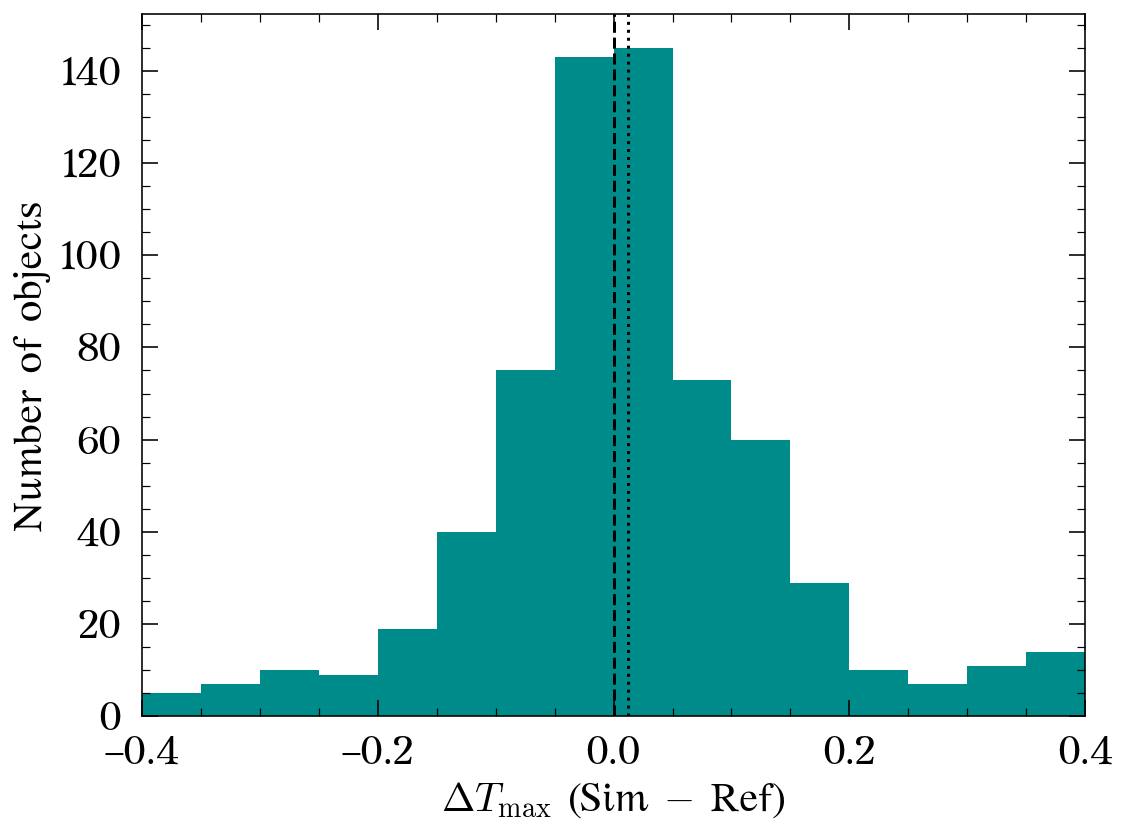

0.012549879843196238


In [12]:
fig, ax = plt.subplots(figsize=(8, 6))

bins = np.arange(-0.45, 0.5, 0.05)
ax.hist(res_df.Tmax_diff, bins, color='darkcyan')
ax.axvline(0, ls='--', c='k')
ax.axvline(res_df.Tmax_diff.mean(), ls='dotted', c='k')

ax.set_xlabel(r'$\Delta T_{\rm max}$ (Sim $-$ Ref)', fontsize=20)
ax.set_ylabel('Number of objects', fontsize=20)
ax.tick_params(labelsize=20)
ax.set_xlim(-0.4, 0.4)

fig.tight_layout()
#plt.savefig('paper_plots/delta_Tmax_cadence.pdf')
plt.show()

print(res_df.Tmax_diff.mean())

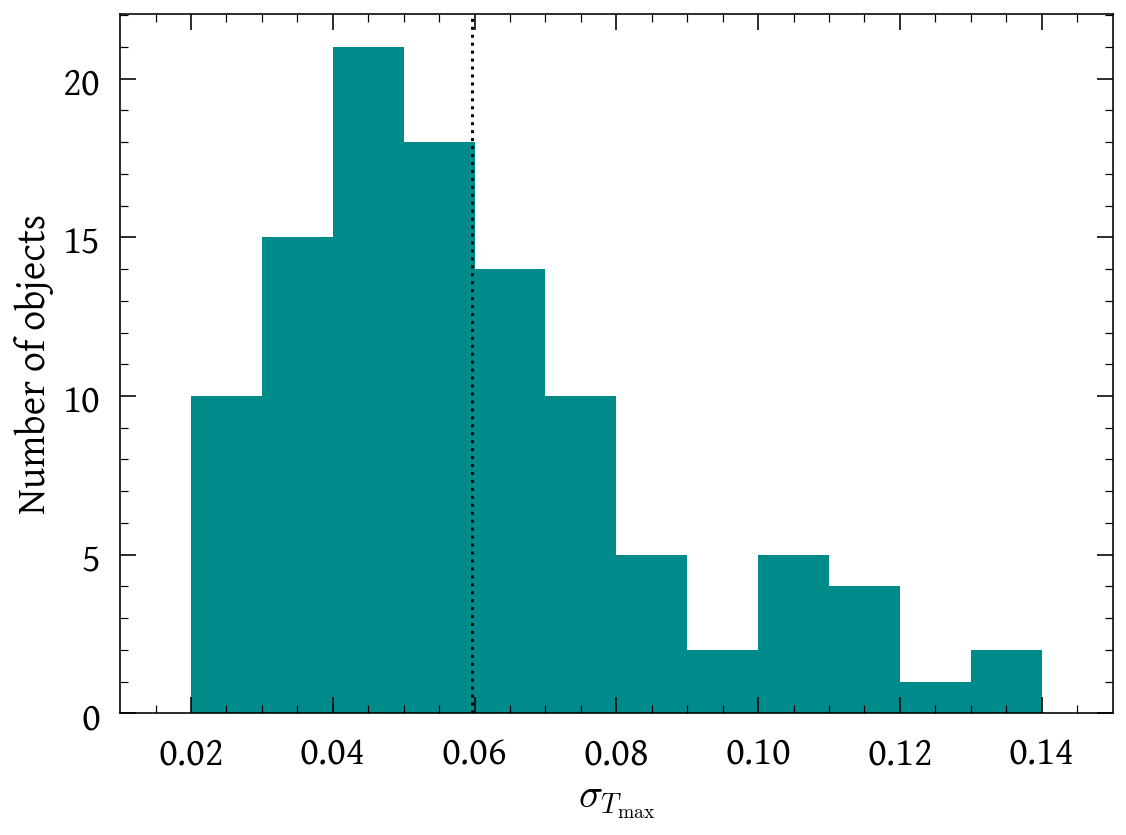

0.059594389160131586


In [10]:
fig, ax = plt.subplots(figsize=(8, 6))

bins = np.arange(0, 0.55, 0.01)
ax.hist(res_df.Tmax_err, bins, color='darkcyan')
ax.axvline(res_df.Tmax_err.mean(), ls='dotted', c='k')

ax.set_xlabel(r'$\sigma_{T_{\rm max}}$', fontsize=20)
ax.set_ylabel('Number of objects', fontsize=20)
ax.tick_params(labelsize=20)
ax.set_xlim(0.01, 0.15)

fig.tight_layout()
plt.savefig('paper_plots/sigma_Tmax_cadence.pdf')
plt.show()
print(res_df.Tmax_err.mean())

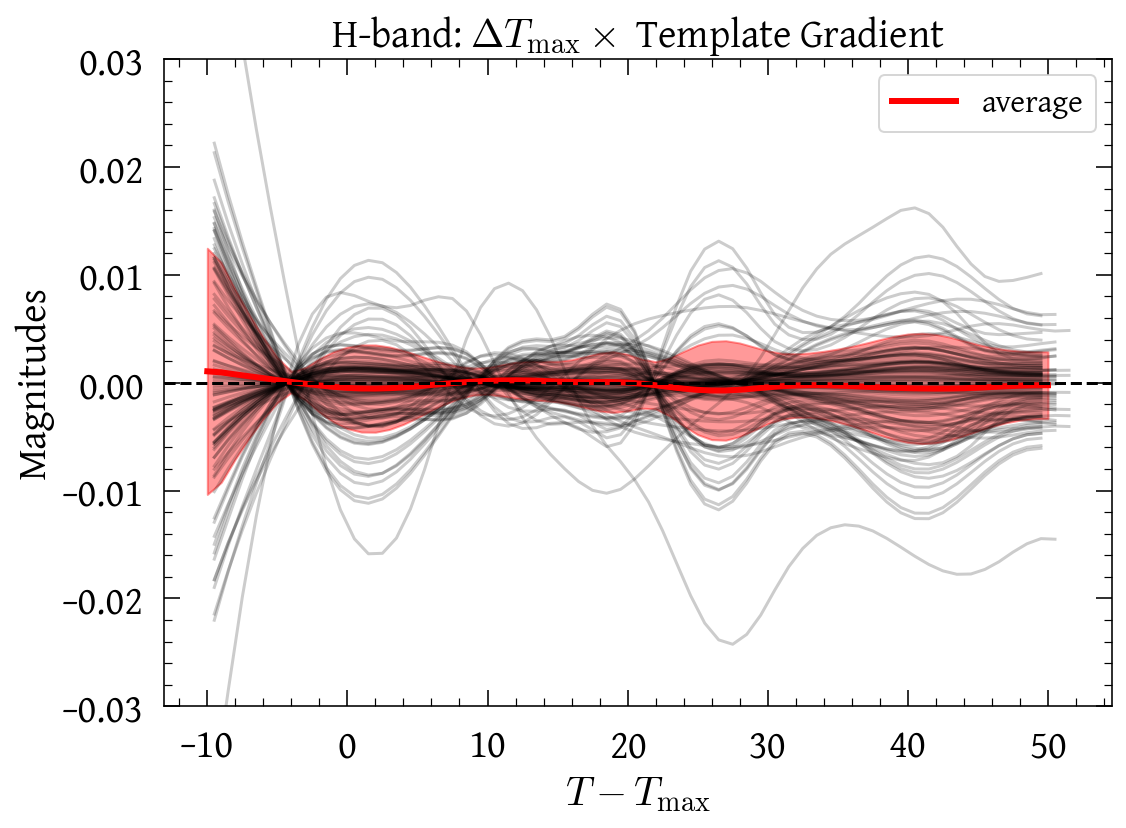

In [35]:
band = 'H'

avg_err = []
epochs = np.arange(-10, 51)

fig, ax = plt.subplots(figsize=(8, 6))
for err, time in zip(lc_snake[band]['err'], 
                     lc_snake[band]['time']):
    
    interp_err = np.interp(epochs, time, err)
    
    # remove weird outliers
    if np.all(np.abs(interp_err)<0.05):
        ax.plot(time, err, 'k', alpha=0.2)
        avg_err.append(interp_err)
    
std_err = np.std(avg_err, axis=0)
avg_err = np.average(avg_err, axis=0)
ax.plot(epochs, avg_err, 'r', label='average', lw=3)
ax.fill_between(epochs, avg_err+std_err, avg_err-std_err, color='r', alpha=0.4)
ax.axhline(0, ls='--', c='k')

ax.set_xlabel(r'$T - T_{\rm max}$', fontsize=20)
ax.set_ylabel('Magnitudes', fontsize=20)
ax.set_title(f'{band}-band: '+r'$\Delta T_{\rm max} \times$ Template Gradient', fontsize=20)
ax.tick_params(labelsize=20)
ax.set_ylim(-0.03, 0.03)
ax.legend(loc=1, fontsize=16)
fig.tight_layout()
plt.savefig(f'paper_plots/Tmax_gradient_cadence_{band}.pdf')
plt.show()

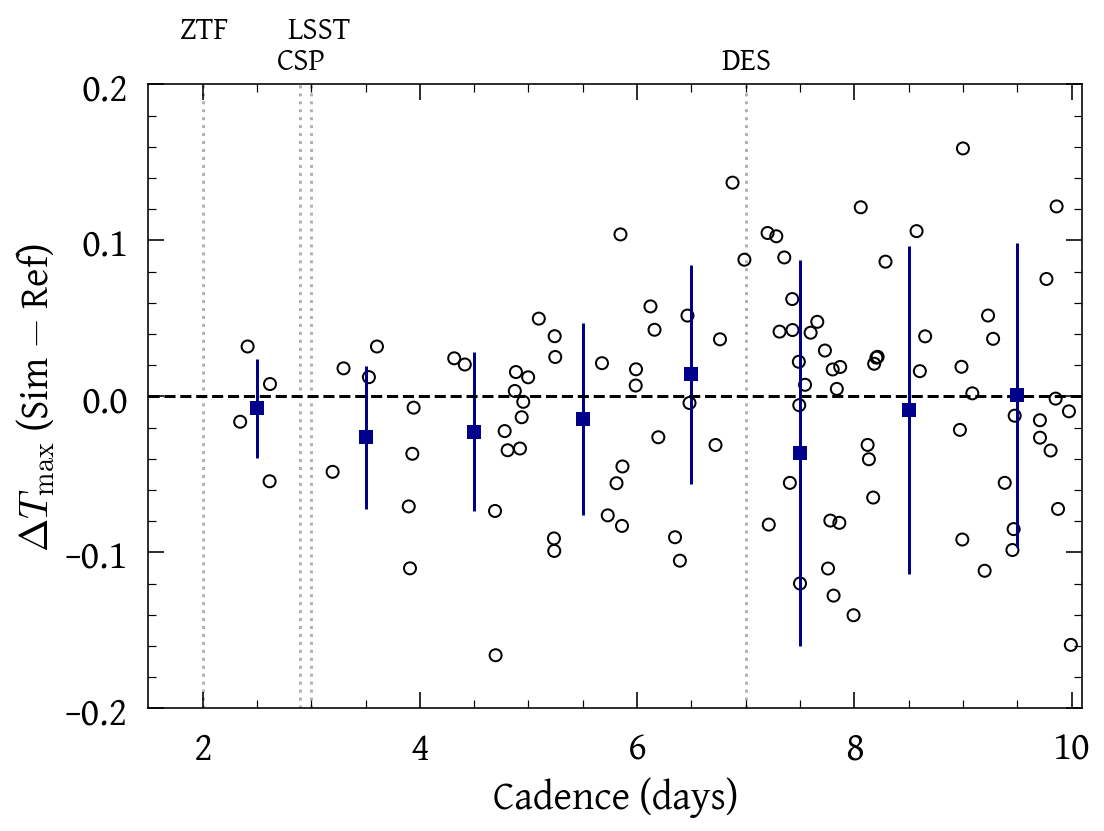

In [33]:
cadence_dict = {'CSP':2.9,
                'ZTF':2,
                'DES':7, 
                'LSST':3}
text_shift = []

bins = np.arange(0, 11, 1)
bins_results =  bin_values(bins, res_df.g.values, 
                           res_df.Tmax_diff.values, 
                           np.ones_like(res_df.g.values))
delta_bins, std_bins, err_bins = bins_results


fig, ax = plt.subplots(figsize=(8, 6))

ax.scatter(res_df.g, res_df.Tmax_diff, marker='o' , ec='k', facecolors='none')
same_cad_df = res_df[res_df.same_cad.values]

# same cadence
#ax.scatter(same_cad_df.g, same_cad_df.Tmax_diff, marker='o', c='m', alpha=0.4)

# bins
ax.errorbar(bins-0.5, delta_bins, yerr=std_bins, fmt='s', c='darkblue')

ax.axhline(0, ls='--', c='k')

for survey, cad in cadence_dict.items():
    if survey in ['ZTF', 'LSST']:
        yoffset = 0.23
    else:
        yoffset = 0.21
    ax.axvline(cad, ls='dotted', c='k', alpha=0.3)
    ax.text(cad-0.22, yoffset, survey, fontsize=16)

ax.set_xlabel(r'Cadence (days)', fontsize=20)
ax.set_ylabel(r'$\Delta T_{\rm max}$ (Sim $-$ Ref)', fontsize=20)
ax.tick_params(labelsize=20)
ax.set_xlim(1.5, 10.1)
ax.set_ylim(-0.2, 0.2)

fig.tight_layout()
plt.savefig(f'paper_plots/delta_Tmax_vs_cadence.pdf')
plt.show()

___

In [200]:
cad_stats_df = pd.read_csv('cadence_stats.csv')
sn_names = cad_stats_df.name.unique()

res_dict = {'Tmax_diff':[], 'Tmax_err':[], 'g':[], 'r':[], 'first_phase':[]}
lc_snake = {band:{'err':[], 'time':[]} for band in ['J', 'H']}

for sn_name in sn_names:
    sn_df = cad_stats_df[cad_stats_df.name==sn_name]
    ref_df = sn_df[sn_df.step==0]
    
    sim_df = sn_df[sn_df.first_phase>=-15]
    sim_df = sim_df[sim_df.g<=10]
    Tmax_diff = sim_df.Tmax.values - ref_df.Tmax.values[0]
    res_dict['Tmax_diff'] += list(Tmax_diff)
    res_dict['Tmax_err'] += list(sim_df.Tmax_err)
    res_dict['g'] += list(sim_df.g)
    res_dict['r'] += list(sim_df.r)
    res_dict['first_phase'] += list(sim_df.first_phase)
            
    lc_dict = extract_gradient(ref_df.st.values[0])
    for band in ['J', 'H']:
        lc = lc_dict[band]
        time = lc['time'][:-1]+0.5
        grad = lc['slope']
        for val in Tmax_diff:
            err = val * grad  # the offset we want per object
            lc_snake[band]['err'].append(err)
            lc_snake[band]['time'].append(time)
            
res_df = pd.DataFrame(res_dict)

In [201]:
cadences = np.arange(1.5, 10.5+step, step)
for i in range(len(cadences)-1):
    cad_min = cadences[i]
    cad_max = cadences[i+1]
    mask = (cad_min<=res_df.g) & (res_df.g<=cad_max)
    cad_df = res_df[mask]

    label = f'{int(cad_min+step/2)} days'
    wmean = np.average(cad_df.Tmax_diff.values, 
                       weights=1/cad_df.Tmax_err.values**2)
    print(f'Mean delta Tmax for cadence={label}: {wmean}')

Mean delta Tmax for cadence=2 days: 0.0032770935783560965
Mean delta Tmax for cadence=3 days: -0.001348409220190163
Mean delta Tmax for cadence=4 days: 0.008707224517472115
Mean delta Tmax for cadence=5 days: 0.047949822491047546
Mean delta Tmax for cadence=6 days: 0.004057313953981215
Mean delta Tmax for cadence=7 days: 0.00041129604651242717
Mean delta Tmax for cadence=8 days: -0.019204200508778597
Mean delta Tmax for cadence=9 days: 0.014992257932426957
Mean delta Tmax for cadence=10 days: 0.0002485734526077743


In [202]:
import seaborn as sns
COLOUR_PALETTE = sns.color_palette('tab10')[1:] + sns.color_palette('tab10')[1:]

Mean delta Tmax for cadence=2 days: 0.0032770935783560965
Mean delta Tmax for cadence=3 days: -0.001348409220190163
Mean delta Tmax for cadence=4 days: 0.008707224517472115
Mean delta Tmax for cadence=5 days: 0.047949822491047546


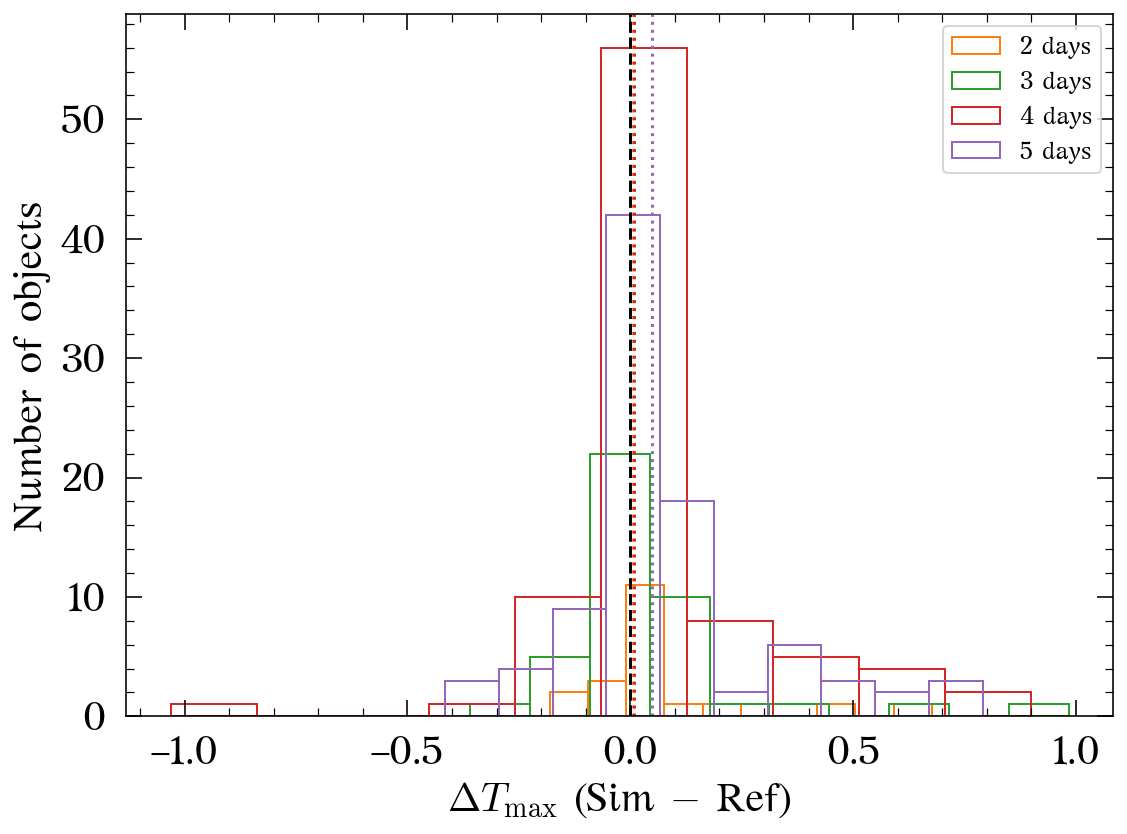

Average delta Tmax: 0.006913781838922793


In [203]:
fig, ax = plt.subplots(figsize=(8, 6))

#bins = np.arange(-2, 2, 0.1)
step = 1
cadences = np.arange(1.5, 5.5+step, step)
for i in range(len(cadences)-1):
    cad_min = cadences[i]
    cad_max = cadences[i+1]
    mask = (cad_min<=res_df.g) & (res_df.g<=cad_max)
    cad_df = res_df[mask]

    colour = COLOUR_PALETTE[i]
    label = f'{int(cad_min+step/2)} days'
    ax.hist(cad_df.Tmax_diff, fc=(0, 0, 0, 0.0), edgecolor=colour, label=label)
    
    wmean = np.average(cad_df.Tmax_diff.values, 
                       weights=1/cad_df.Tmax_err.values**2)
    ax.axvline(wmean, ls='dotted', c=colour)
    print(f'Mean delta Tmax for cadence={label}: {wmean}')
    
ax.axvline(0, ls='--', c='k')

ax.set_xlabel(r'$\Delta T_{\rm max}$ (Sim $-$ Ref)', fontsize=20)
ax.set_ylabel('Number of objects', fontsize=20)
ax.tick_params(labelsize=20)
#ax.set_xlim(-2, 2)
ax.legend()

fig.tight_layout()
plt.show()

mask = ~np.isnan(res_df.Tmax_err.values)
mask = res_df.Tmax_err.values>0.0
wmean = np.average(res_df.Tmax_diff.values[mask], 
                       weights=1/res_df.Tmax_err.values[mask]**2)
print(f'Average delta Tmax: {wmean}')

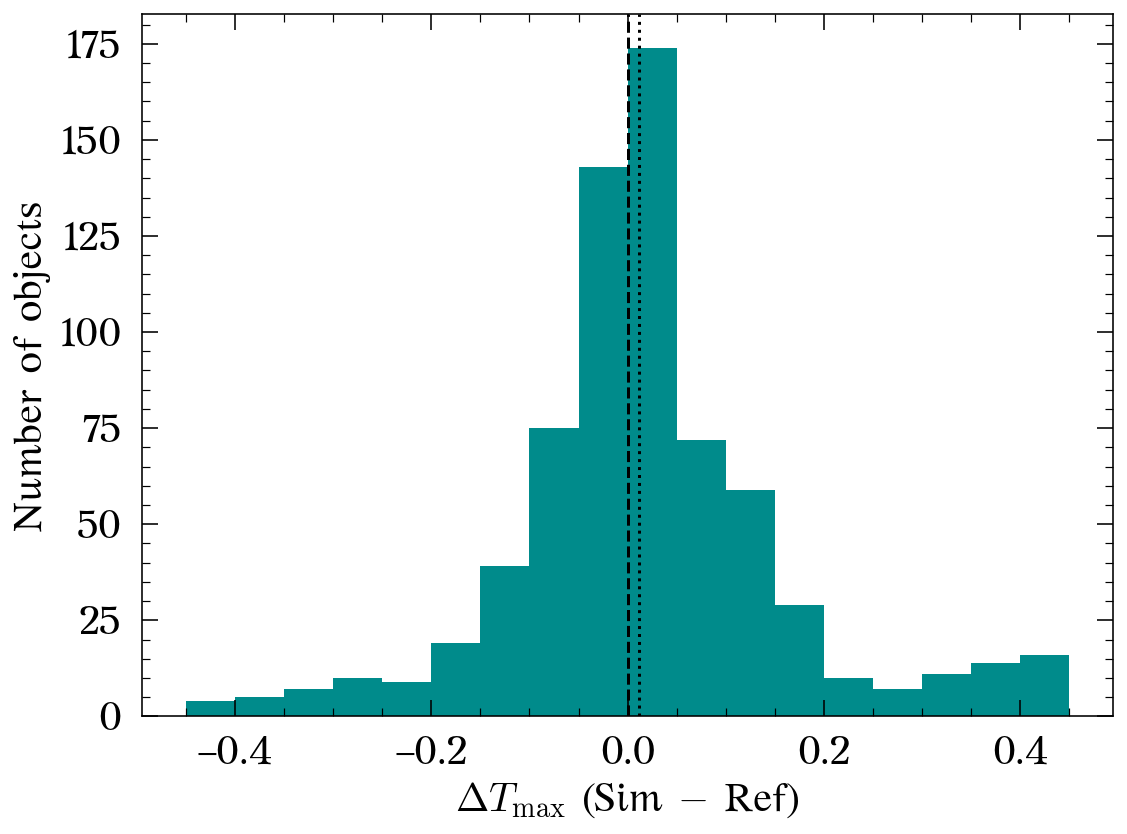

0.012032790939164829


In [208]:
fig, ax = plt.subplots(figsize=(8, 6))

bins = np.arange(-0.45, 0.5, 0.05)
ax.hist(res_df.Tmax_diff, bins, color='darkcyan')
ax.axvline(0, ls='--', c='k')
ax.axvline(res_df.Tmax_diff.mean(), ls='dotted', c='k')

ax.set_xlabel(r'$\Delta T_{\rm max}$ (Sim $-$ Ref)', fontsize=20)
ax.set_ylabel('Number of objects', fontsize=20)
ax.tick_params(labelsize=20)
#ax.set_xlim(-0.4, 0.4)

fig.tight_layout()
plt.savefig('paper_plots/delta_Tmax_cadence.pdf')
plt.show()

print(res_df.Tmax_diff.mean())

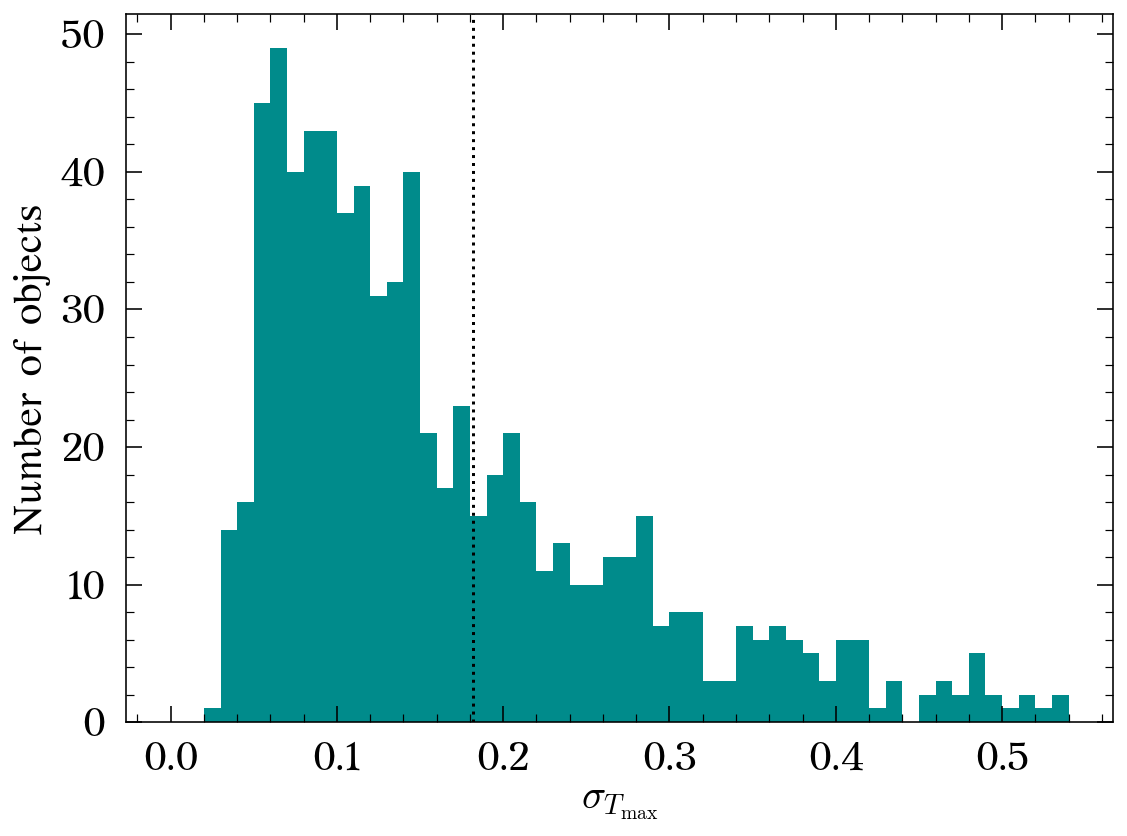

0.18200168427124927


In [209]:
fig, ax = plt.subplots(figsize=(8, 6))

bins = np.arange(0, 0.55, 0.01)
ax.hist(res_df.Tmax_err, bins, color='darkcyan')
ax.axvline(res_df.Tmax_err.mean(), ls='dotted', c='k')

ax.set_xlabel(r'$\sigma_{T_{\rm max}}$', fontsize=20)
ax.set_ylabel('Number of objects', fontsize=20)
ax.tick_params(labelsize=20)
#ax.set_xlim(0.01, 0.15)

fig.tight_layout()
plt.savefig('paper_plots/sigma_Tmax_cadence.pdf')
plt.show()
print(res_df.Tmax_err.mean())

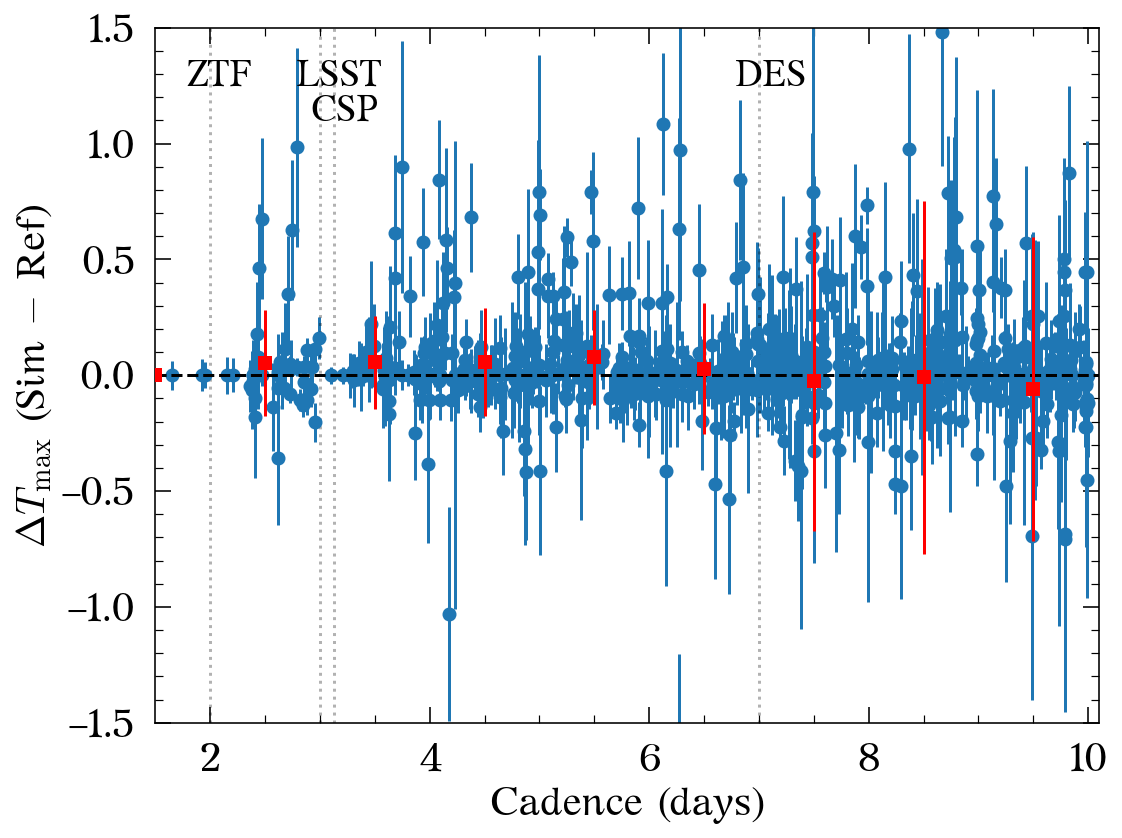

In [207]:
# average CSP cadence
avg_cad = []
for sn_name in sn_names:
    sn_df = cad_stats_df[cad_stats_df.name==sn_name]
    sn_df = sn_df[sn_df.step==0]
    cad = sn_df.g.values[0]
    avg_cad.append(cad)
    
avg_cad = np.array(avg_cad).mean()

cadence_dict = {'CSP':avg_cad,
                'ZTF':2,
                'DES':7, 
                'LSST':3}
text_shift = []

bins = np.arange(0, 11, 1)
bins_results =  bin_values(bins, res_df.g.values, 
                           res_df.Tmax_diff.values, 
                           np.ones_like(res_df.g.values))
delta_bins, std_bins, err_bins = bins_results


fig, ax = plt.subplots(figsize=(8, 6))

#ax.scatter(res_df.g, res_df.Tmax_diff, marker='o' , ec='k', facecolors='none')
ax.errorbar(res_df.g, res_df.Tmax_diff, yerr=res_df.Tmax_err, fmt='o')

# bins
ax.errorbar(bins-0.5, delta_bins, yerr=std_bins, fmt='s', c='red', zorder=10)

ax.axhline(0, ls='--', c='k', zorder=5)

for survey, cad in cadence_dict.items():
    if survey in ['ZTF', 'LSST', 'DES']:
        yoffset = 1.25
    else:
        yoffset = 1.1
    ax.axvline(cad, ls='dotted', c='k', alpha=0.3)
    ax.text(cad-0.22, yoffset, survey, fontsize=18)

ax.set_xlabel(r'Cadence (days)', fontsize=20)
ax.set_ylabel(r'$\Delta T_{\rm max}$ (Sim $-$ Ref)', fontsize=20)
ax.tick_params(labelsize=20)
ax.set_xlim(1.5, 10.1)
ax.set_ylim(-1.5, 1.5)

fig.tight_layout()
plt.savefig(f'paper_plots/delta_Tmax_vs_cadence.pdf')
plt.show()

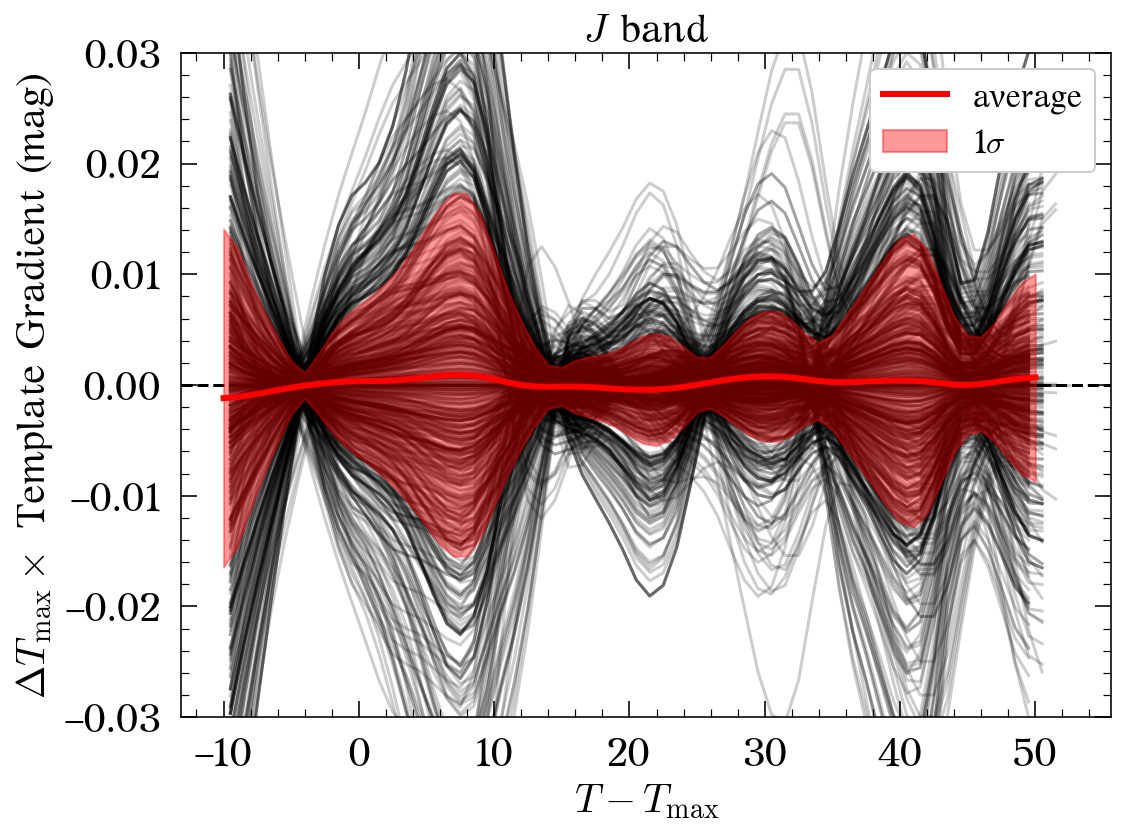

In [211]:
band = 'J'

avg_err = []
epochs = np.arange(-10, 51)

fig, ax = plt.subplots(figsize=(8, 6))
for err, time in zip(lc_snake[band]['err'], 
                     lc_snake[band]['time']):
    
    interp_err = np.interp(epochs, time, err)
    
    # remove weird outliers
    if np.all(np.abs(interp_err)<0.05):
        ax.plot(time, err, 'k', alpha=0.2)
        avg_err.append(interp_err)
    
std_err = np.std(avg_err, axis=0)
avg_err = np.average(avg_err, axis=0)
ax.plot(epochs, avg_err, 'r', label='average', lw=3, zorder=30)
ax.fill_between(epochs, avg_err+std_err, avg_err-std_err, 
                color='r', alpha=0.4, label='1$\sigma$', zorder=20)
ax.axhline(0, ls='--', c='k')

ax.set_xlabel(r'$T - T_{\rm max}$', fontsize=20)
ax.set_ylabel(r'$\Delta T_{\rm max} \times$ Template Gradient (mag)', fontsize=20)
ax.set_title(f'${band}$ band', fontsize=20)
ax.tick_params(labelsize=20)
ax.set_ylim(-0.03, 0.03)
ax.legend(loc=1, fontsize=16, framealpha=1).set_zorder(10)
fig.tight_layout()
plt.savefig(f'paper_plots/Tmax_gradient_cadence_{band}.pdf')
plt.show()

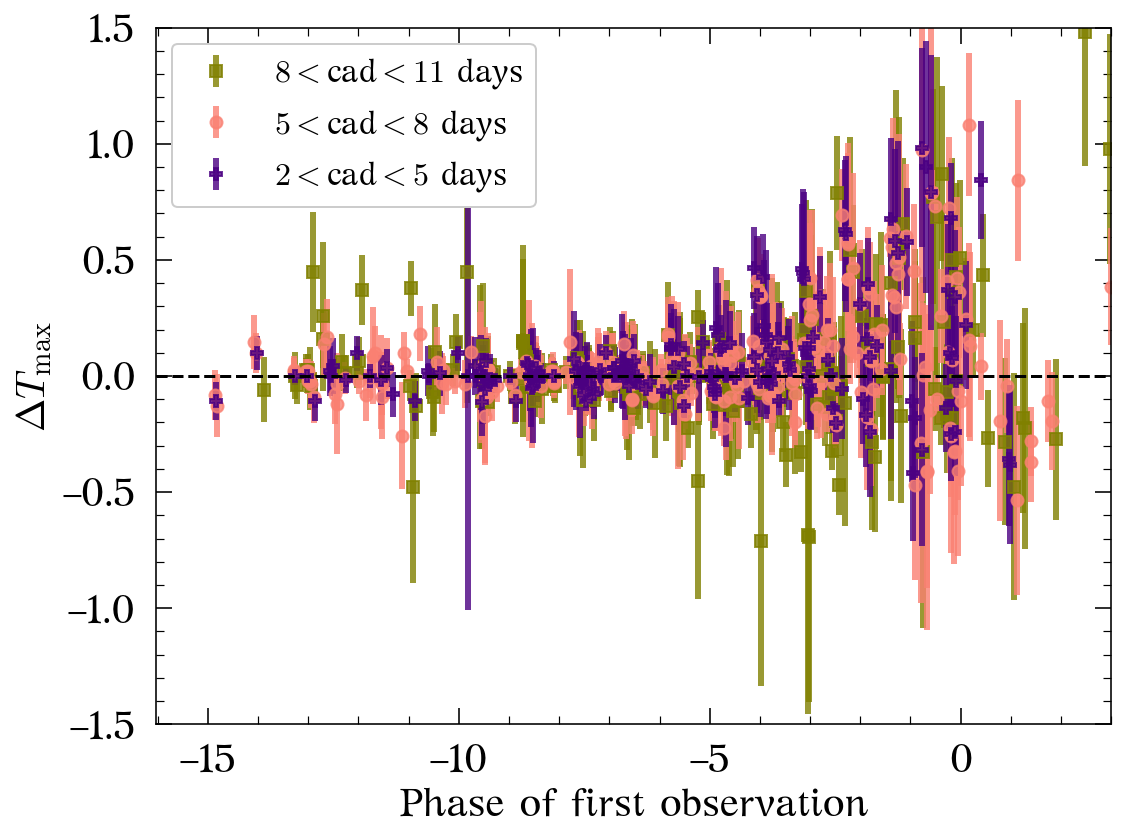

In [212]:
cadences = np.arange(2, 12, 3)[::-1]
colours = ['olive', 'salmon', 'indigo']
markers = ['s', 'o', 'P']

fig, ax = plt.subplots(figsize=(8, 6))

for i in range(len(cadences)-1):
    mask = (res_df.g>cadences[i+1]) & (res_df.g<cadences[i])
    cad_df = res_df[mask]
    x = cad_df.first_phase.values
    y = cad_df.Tmax_diff.values
    yerr = cad_df.Tmax_err.values

    label = f'${cadences[i+1]}<$cad$<{cadences[i]}$ days'
    colour = colours[i]
    marker = markers[i]
    ax.errorbar(x, y, yerr=yerr, fmt=marker, lw=3, 
                label=label, alpha=0.8, c=colour)
    
ax.axhline(0, ls='--', c='k', zorder=10)

ax.set_xlabel(r'Phase of first observation', fontsize=20)
ax.set_ylabel(r'$\Delta T_{\rm max}$', fontsize=20)
ax.tick_params(labelsize=20)
ax.set_ylim(-1.5, 1.5)
ax.set_xlim(None, 3)
ax.legend(loc=2, fontsize=16, framealpha=1).set_zorder(20)
fig.tight_layout()
plt.savefig(f'paper_plots/Tmax_running_cadence.pdf')
plt.show()

___
## Signal-to-Noise

In [219]:
bands = ['g', 'r']
multi = range(2, 7)

with open('reference_files.txt') as ref_file:
    sn_files = ref_file.read().splitlines()

snr_list = Pool(PROCESSES).map(pool_fit_snr, ([sn_file, multi, bands] for sn_file in sn_files))

/tmp/ipykernel_1366/1412621745.py:211: RuntimeWarning: invalid value encountered in log10
  new_mag = -2.5*np.log10(new_flux) + zp
/tmp/ipykernel_1366/1412621745.py:211: RuntimeWarning: invalid value encountered in log10
  new_mag = -2.5*np.log10(new_flux) + zp
/home/tomas/anaconda3/envs/flows_sims/lib/python3.10/site-packages/snpy/sn.py:360: RuntimeWarning: invalid value encountered in log10
  temp1[i] = -2.5*log10(af) + self.data[band].filter.zp


In [220]:
snr_stats_df = pd.concat(snr_list, ignore_index=True)
snr_stats_df.to_csv('snr_stats.csv', index=False)

___
### Signal-to-Noise Analysis

In [282]:
snr_stats_df = pd.read_csv('snr_stats.csv')
sn_names = cad_stats_df.name.unique()

res_dict = {'Tmax_diff':[], 'Tmax_err':[], 'g':[], 'r':[]}
lc_snake = {band:{'err':[], 'time':[]} for band in ['J', 'H']}

for sn_name in sn_names:
    sn_df = snr_stats_df[snr_stats_df.name==sn_name]
    ref_df = sn_df[sn_df.B>0]
        
    sim_df = sn_df[sn_df.g<=500]
    Tmax_diff = sim_df.Tmax.values - ref_df.Tmax.values[0]
    res_dict['Tmax_diff'] += list(Tmax_diff)
    res_dict['Tmax_err'] += list(sim_df.Tmax_err)
    res_dict['g'] += list(sim_df.g)
    res_dict['r'] += list(sim_df.r)
            
    lc_dict = extract_gradient(ref_df.st.values[0])
    for band in ['J', 'H']:
        lc = lc_dict[band]
        time = lc['time'][:-1]+0.5
        grad = lc['slope']
        for val in Tmax_diff:
            err = val * grad  # the offset we want per object
            lc_snake[band]['err'].append(err)
            lc_snake[band]['time'].append(time)
            
res_df = pd.DataFrame(res_dict)
# weird outliers
res_df = res_df[res_df.Tmax_diff>-2]
res_df = res_df[res_df.Tmax_err>0.001]

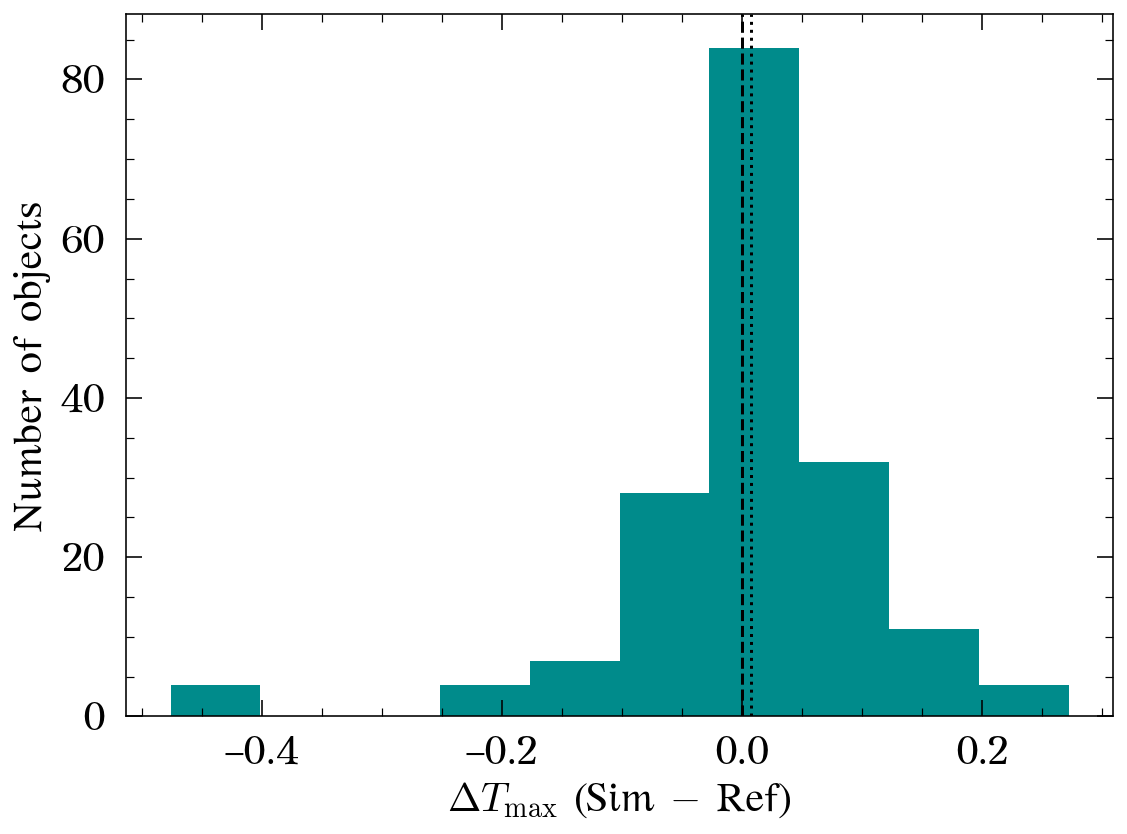

0.007435023543011321


In [283]:
fig, ax = plt.subplots(figsize=(8, 6))

#bins = np.arange(-1.0, 1.05, 0.05)
ax.hist(res_df.Tmax_diff, color='darkcyan')
ax.axvline(0, ls='--', c='k')
wmean = np.average(res_df.Tmax_diff.values, 
                   weights=1/res_df.Tmax_err.values**2)
ax.axvline(wmean, ls='dotted', c='k')

ax.set_xlabel(r'$\Delta T_{\rm max}$ (Sim $-$ Ref)', fontsize=20)
ax.set_ylabel('Number of objects', fontsize=20)
ax.tick_params(labelsize=20)
#ax.set_xlim(-0.9, 0.9)

fig.tight_layout()
plt.savefig('paper_plots/delta_Tmax_snr.pdf')
plt.show()

print(wmean)

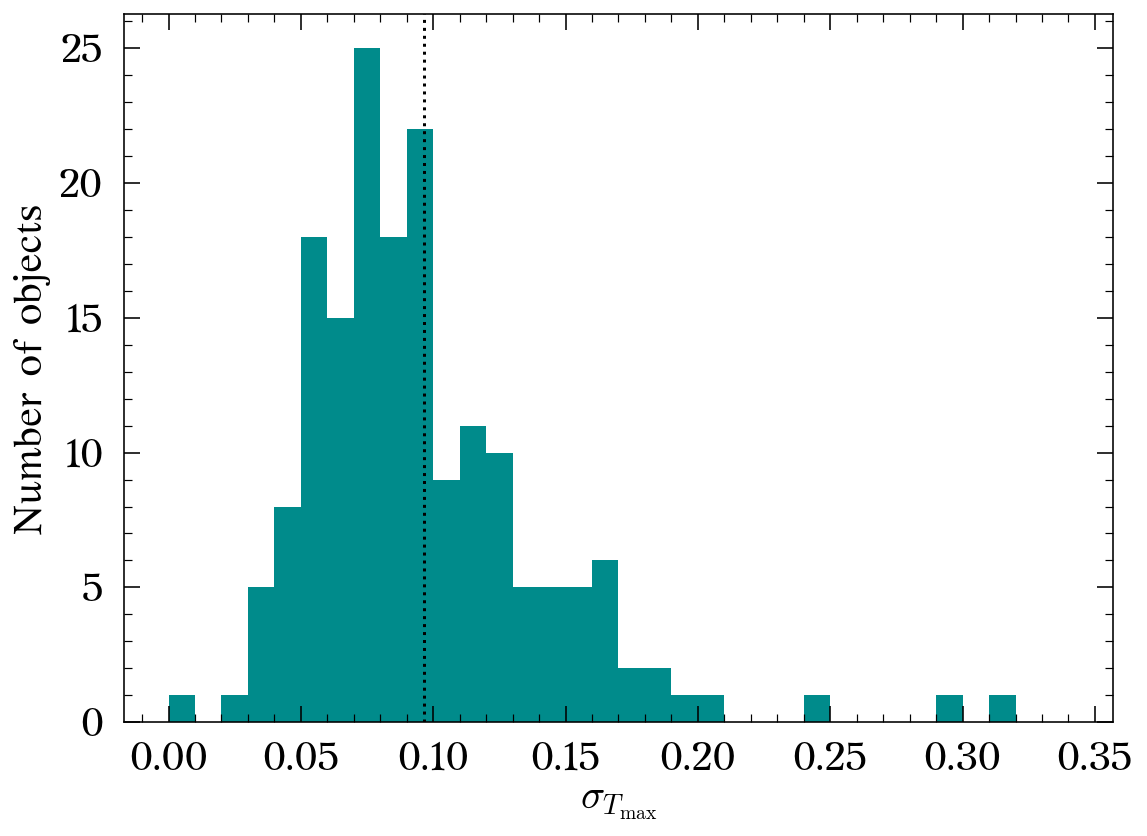

0.09653607556644936


In [286]:
# remove large uncertainty that can shift the mean
df = res_df[res_df.Tmax_err < 0.5]  

fig, ax = plt.subplots(figsize=(8, 6))

bins = np.arange(0, 0.35, 0.01)
ax.hist(df.Tmax_err, bins, color='darkcyan')
ax.axvline(df.Tmax_err.mean(), ls='dotted', c='k')

ax.set_xlabel(r'$\sigma_{T_{\rm max}}$', fontsize=20)
ax.set_ylabel('Number of objects', fontsize=20)
ax.tick_params(labelsize=20)
#ax.set_xlim(0, 0.55)

fig.tight_layout()
plt.savefig('paper_plots/sigma_Tmax_snr.pdf')
plt.show()

print(df.Tmax_err.mean())

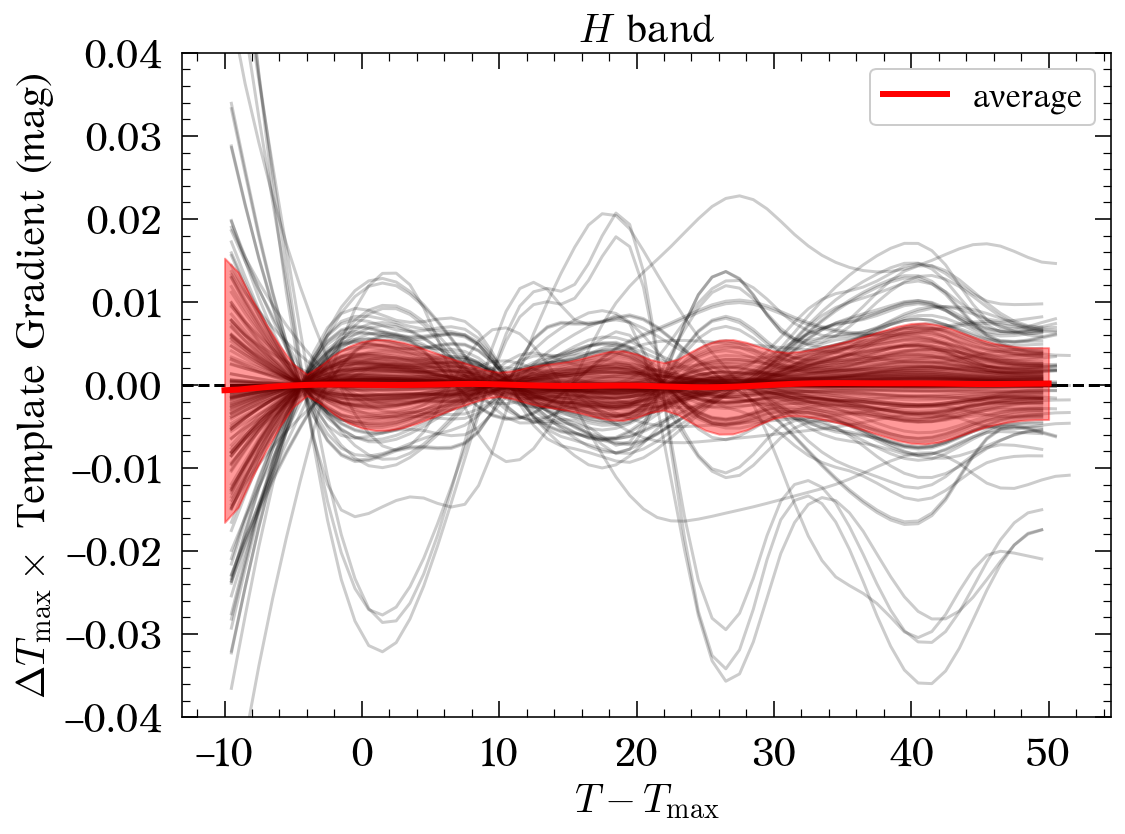

In [293]:
band = 'H'

avg_err = []
epochs = np.arange(-10, 51)

fig, ax = plt.subplots(figsize=(8, 6))
for err, time in zip(lc_snake[band]['err'], 
                     lc_snake[band]['time']):
    
    interp_err = np.interp(epochs, time, err)
    
    # remove weird outliers
    if np.all(np.abs(interp_err)<0.1):
        ax.plot(time, err, 'k', alpha=0.2)
        avg_err.append(interp_err)
    
std_err = np.std(avg_err, axis=0)
avg_err = np.average(avg_err, axis=0)
ax.plot(epochs, avg_err, 'r', label='average', lw=3, zorder=30)
ax.fill_between(epochs, avg_err+std_err, avg_err-std_err, 
                color='r', alpha=0.4, zorder=20)
ax.axhline(0, ls='--', c='k')

ax.set_xlabel(r'$T - T_{\rm max}$', fontsize=20)
ax.set_ylabel(r'$\Delta T_{\rm max} \times$ Template Gradient (mag)', fontsize=20)
ax.set_title(f'${band}$ band', fontsize=20)
ax.tick_params(labelsize=20)
ax.set_ylim(-0.04, 0.04)
ax.legend(loc=1, fontsize=16, framealpha=1).set_zorder(20)
fig.tight_layout()
plt.savefig(f'paper_plots/Tmax_gradient_snr_{band}.pdf')
plt.show()

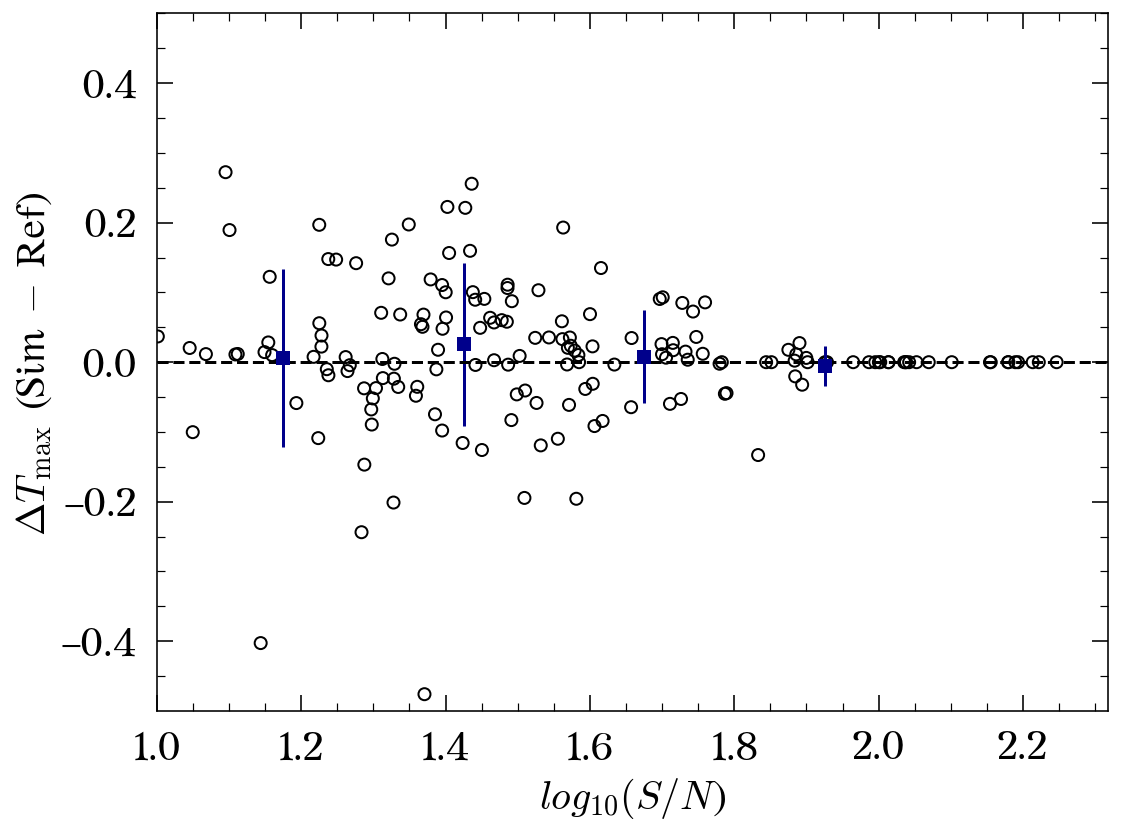

In [296]:
df = res_df[np.abs(res_df.Tmax_diff)<0.85]  # weird outliers

step = 0.25
bins = np.arange(0.8, 2.0+step, step)
bins_results =  bin_values(bins, np.log10(df.g.values), 
                           df.Tmax_diff.values, 
                           np.ones_like(df.g.values))
delta_bins, std_bins, err_bins = bins_results


fig, ax = plt.subplots(figsize=(8, 6))

ax.scatter(np.log10(df.g), df.Tmax_diff, marker='o' , ec='k', facecolors='none')

# bins
ax.errorbar(bins-step/2, delta_bins, yerr=std_bins, fmt='s', c='darkblue')

ax.axhline(0, ls='--', c='k')

ax.set_xlabel(r'$log_{10}(S/N$)', fontsize=20)
ax.set_ylabel(r'$\Delta T_{\rm max}$ (Sim $-$ Ref)', fontsize=20)
ax.tick_params(labelsize=20)
ax.set_ylim(-0.5, 0.5)
ax.set_xlim(1, None)

fig.tight_layout()
plt.savefig(f'paper_plots/delta_Tmax_vs_snr.pdf')
plt.show()

___

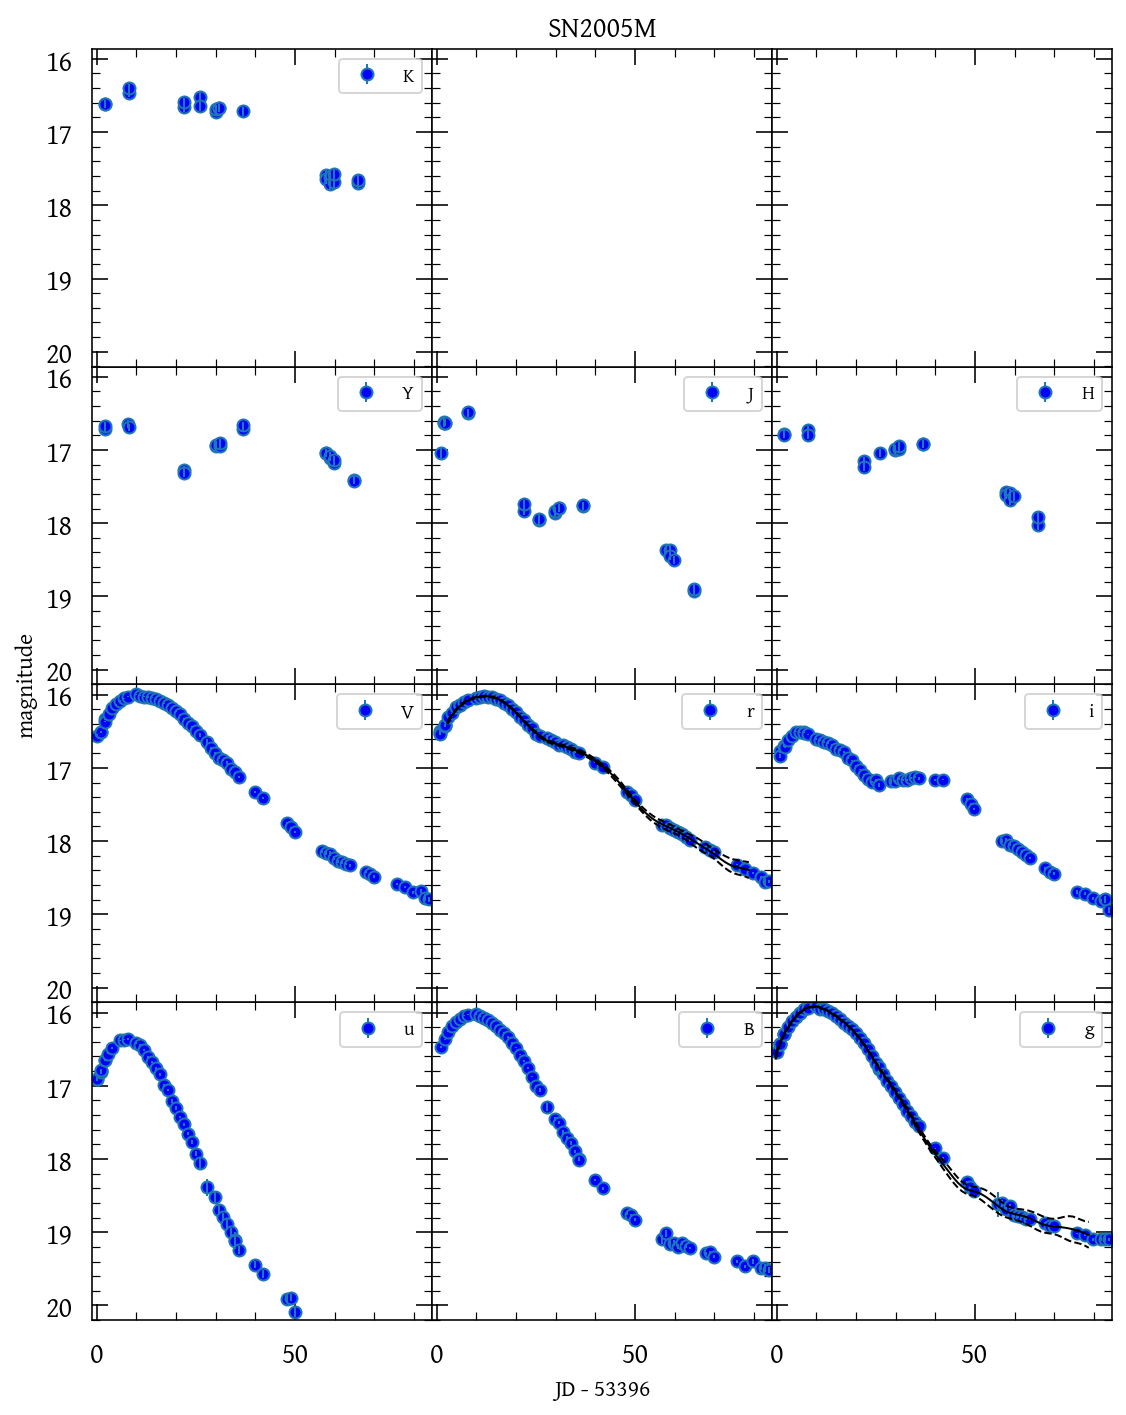

53405.98139856311


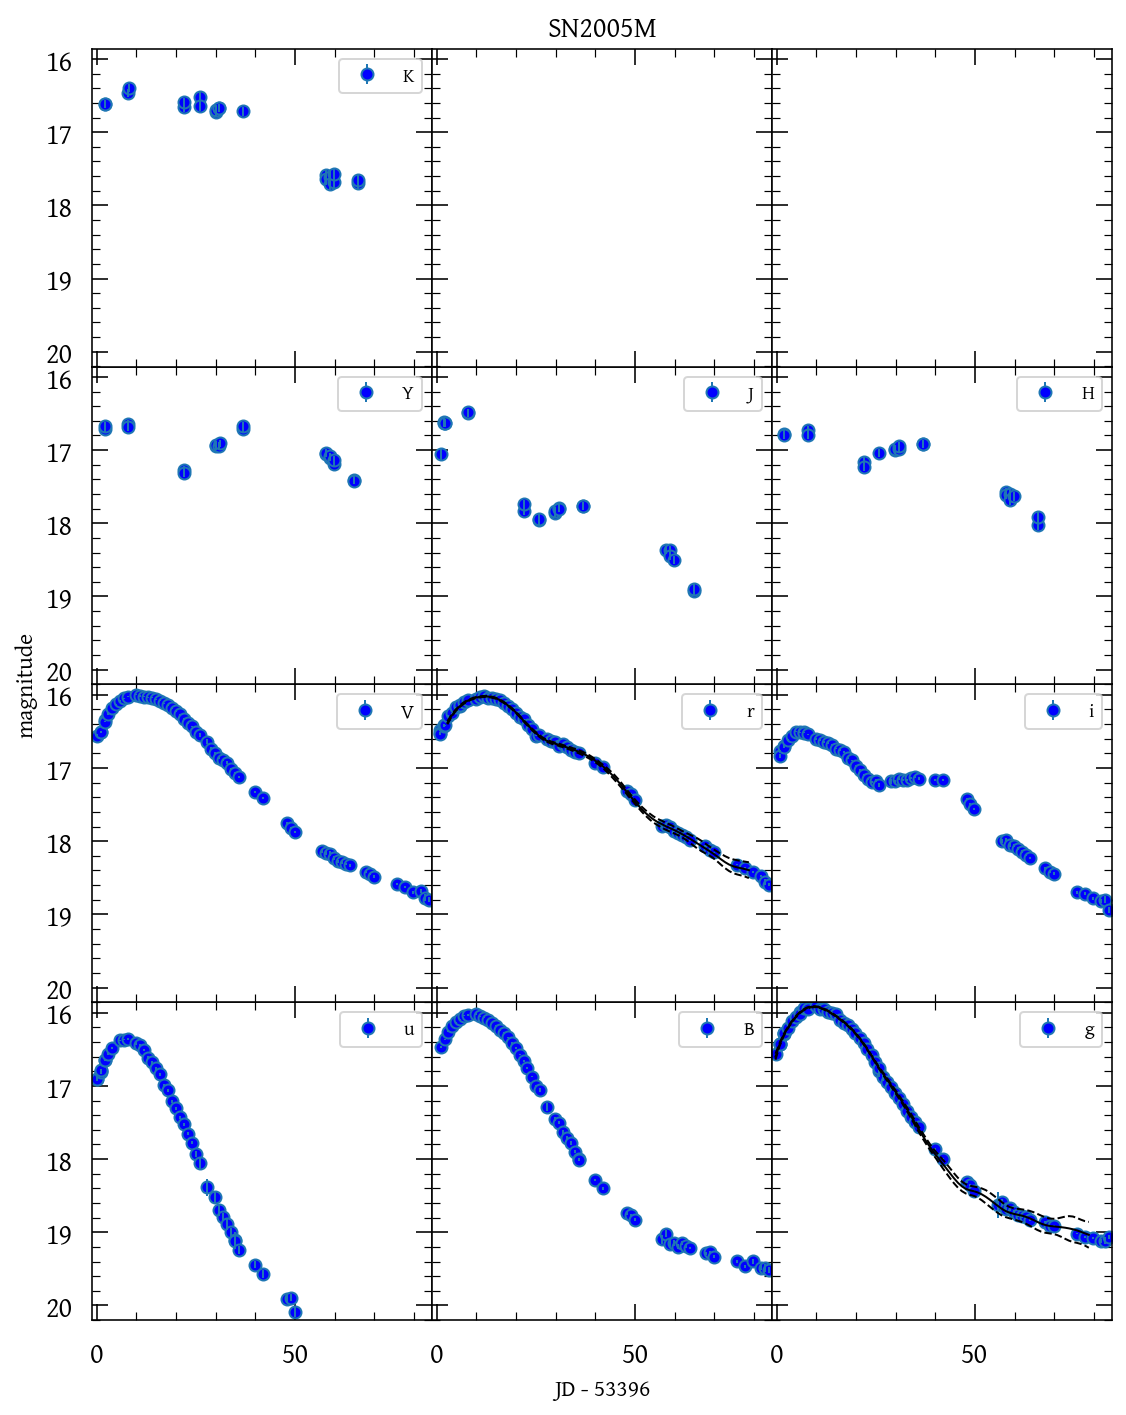

53405.991978438775


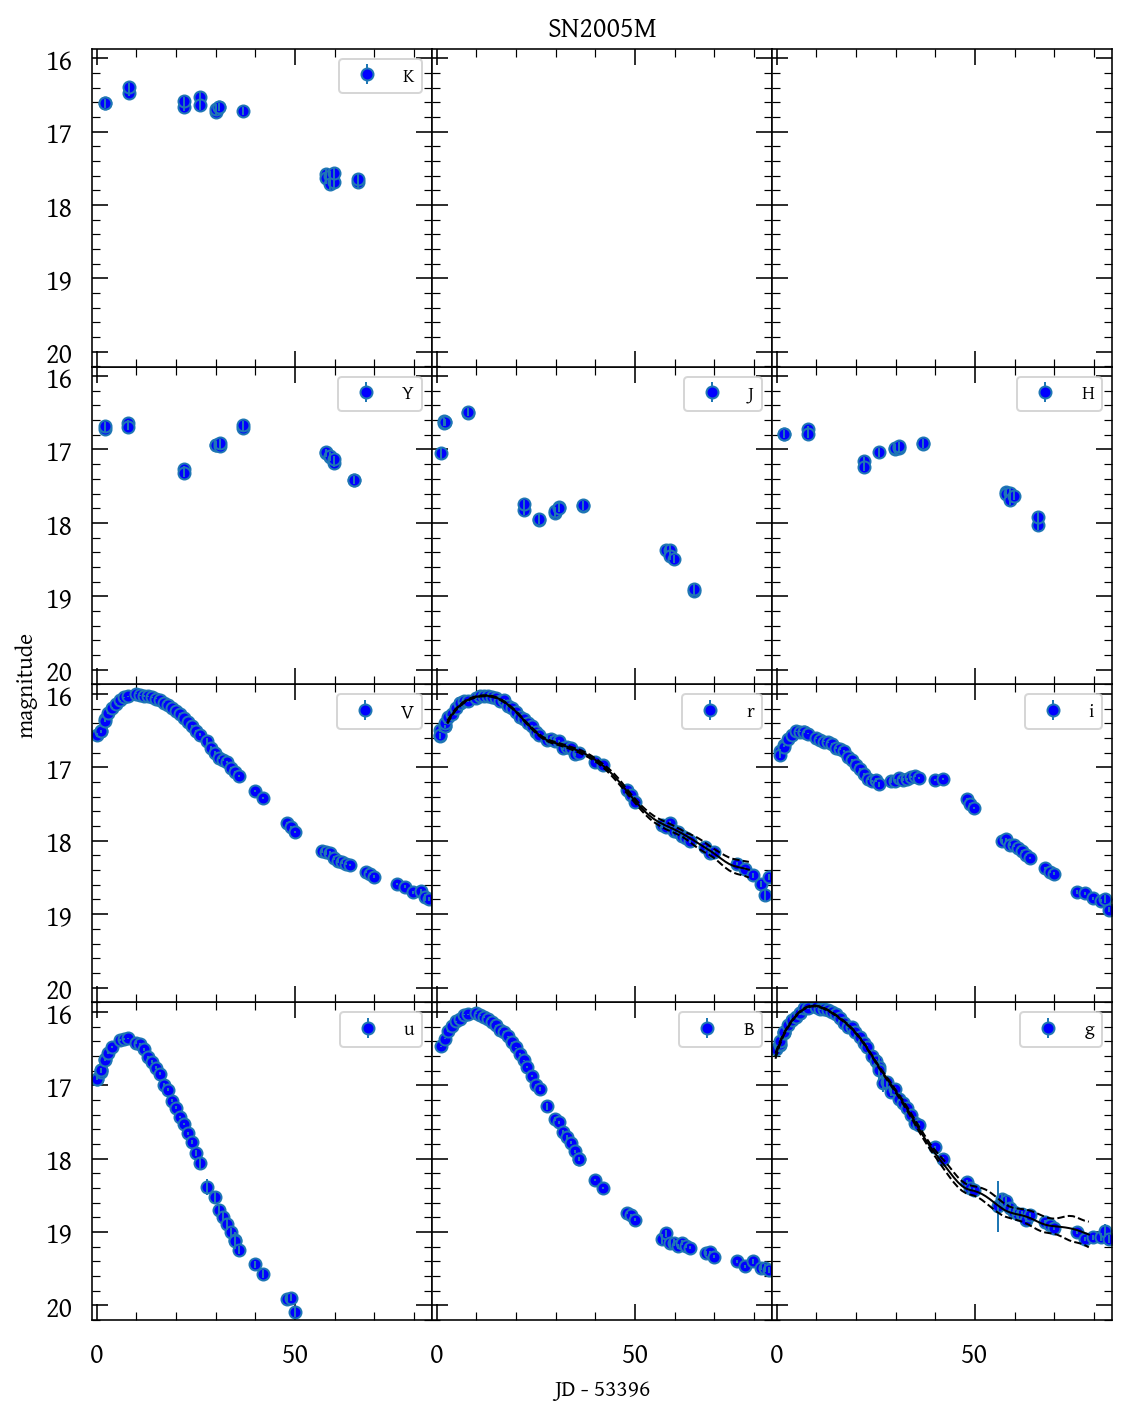

53405.987653208176


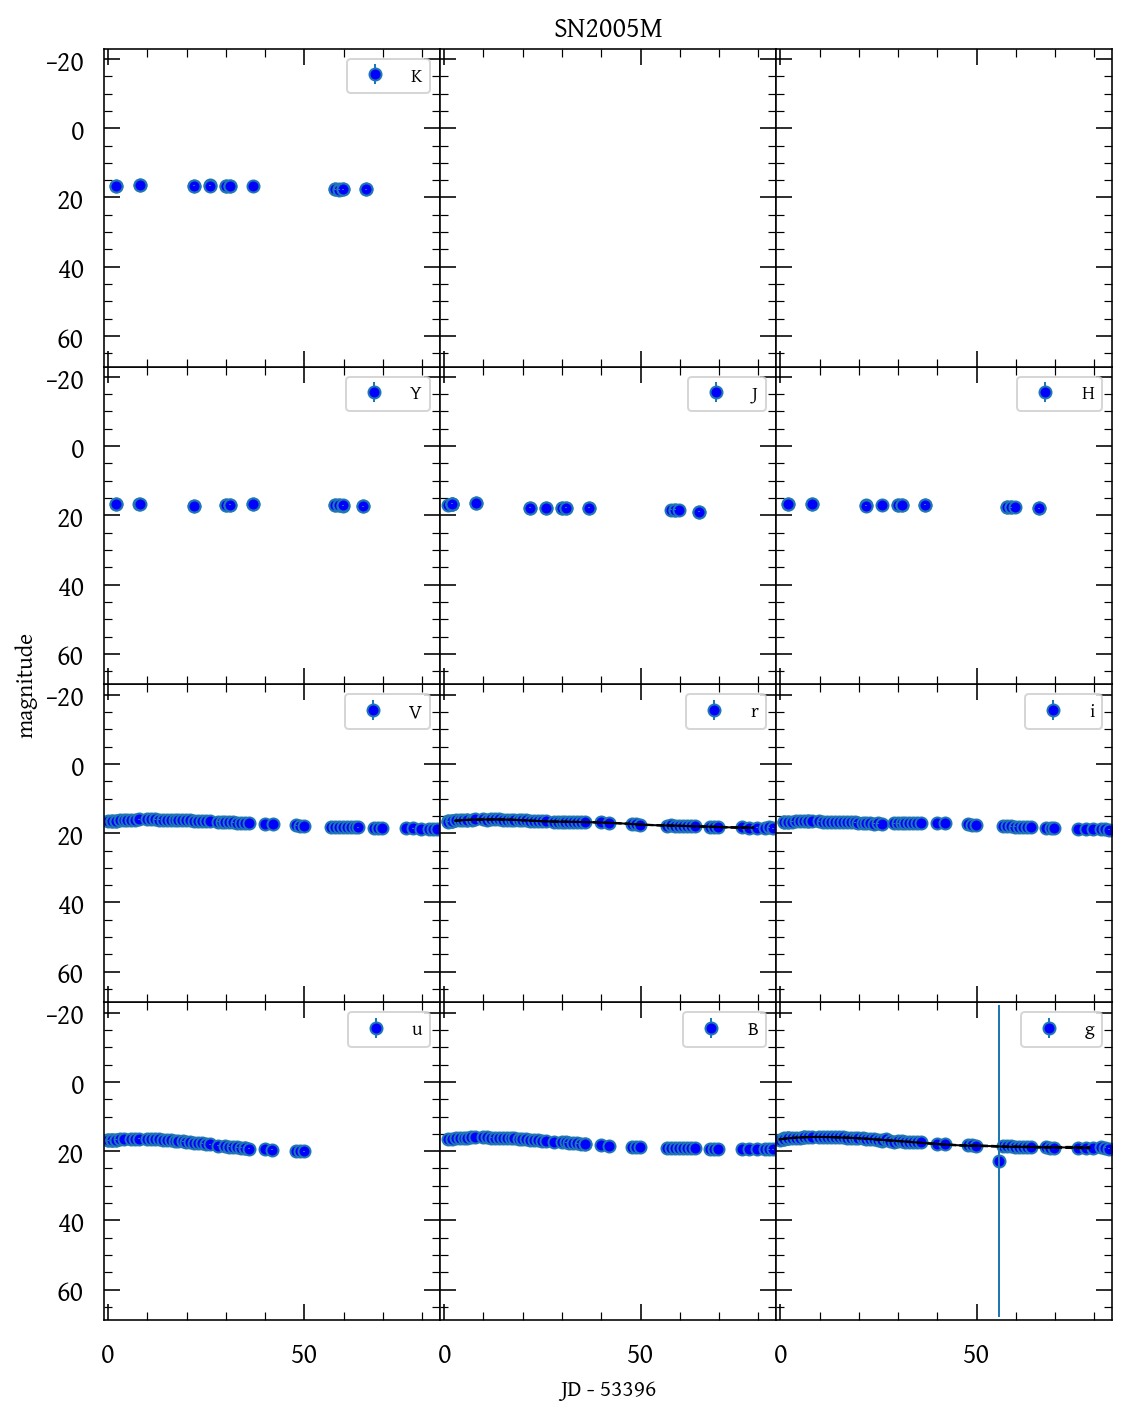

53406.07692386081


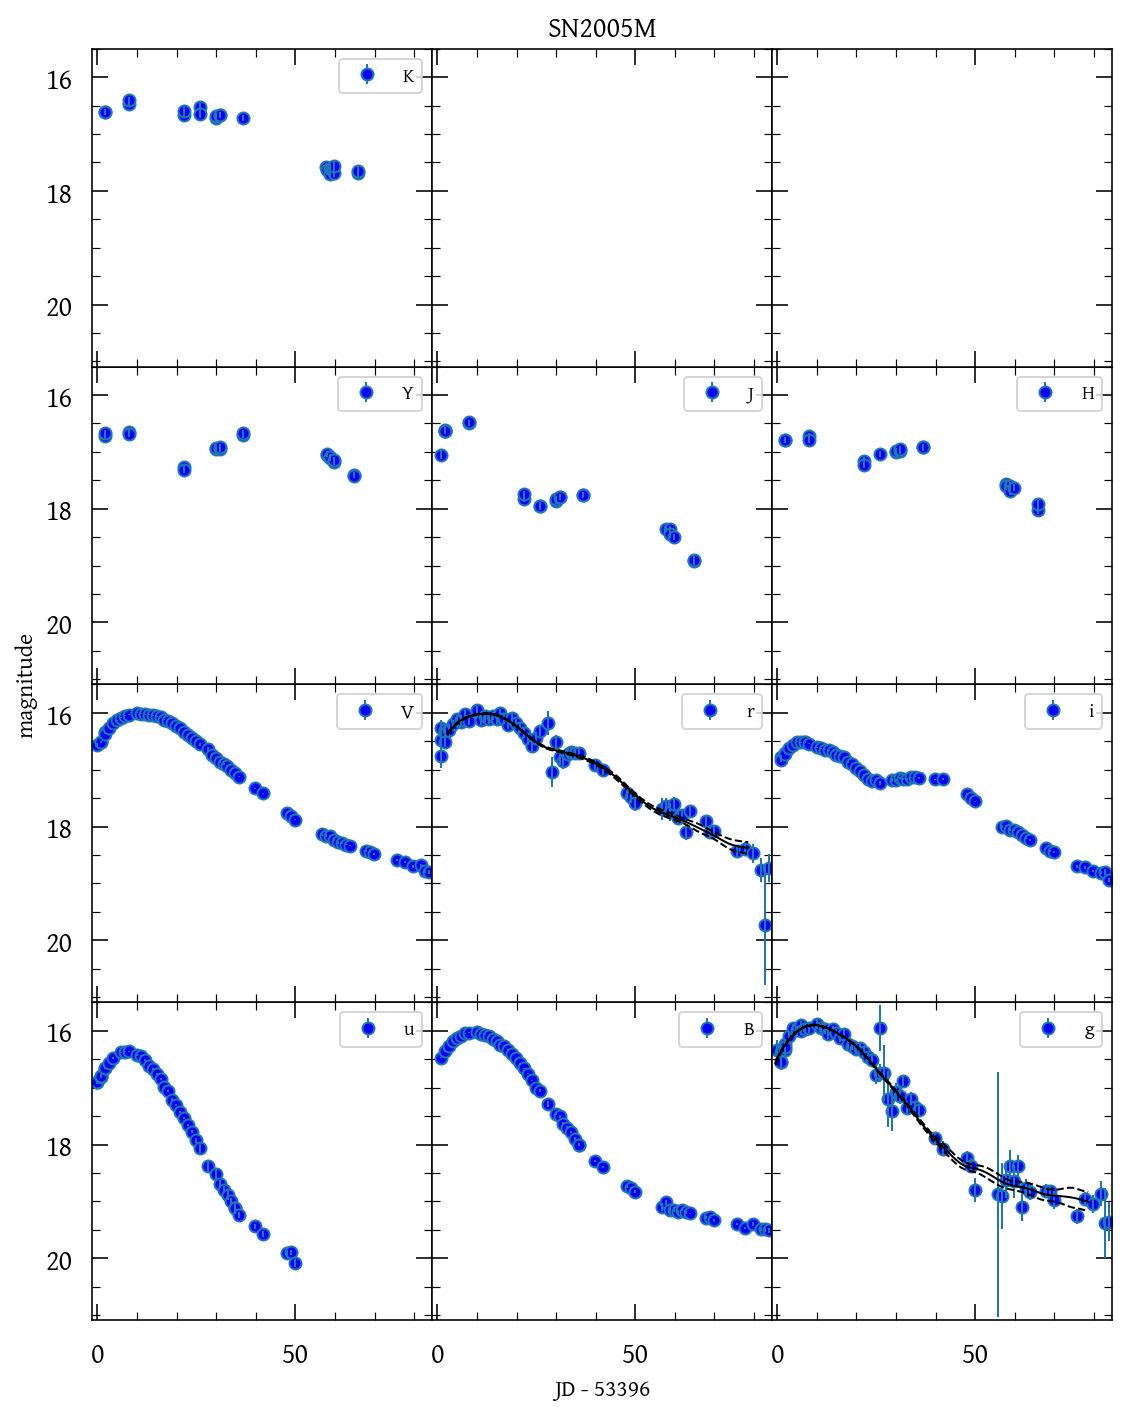

53405.82830839992


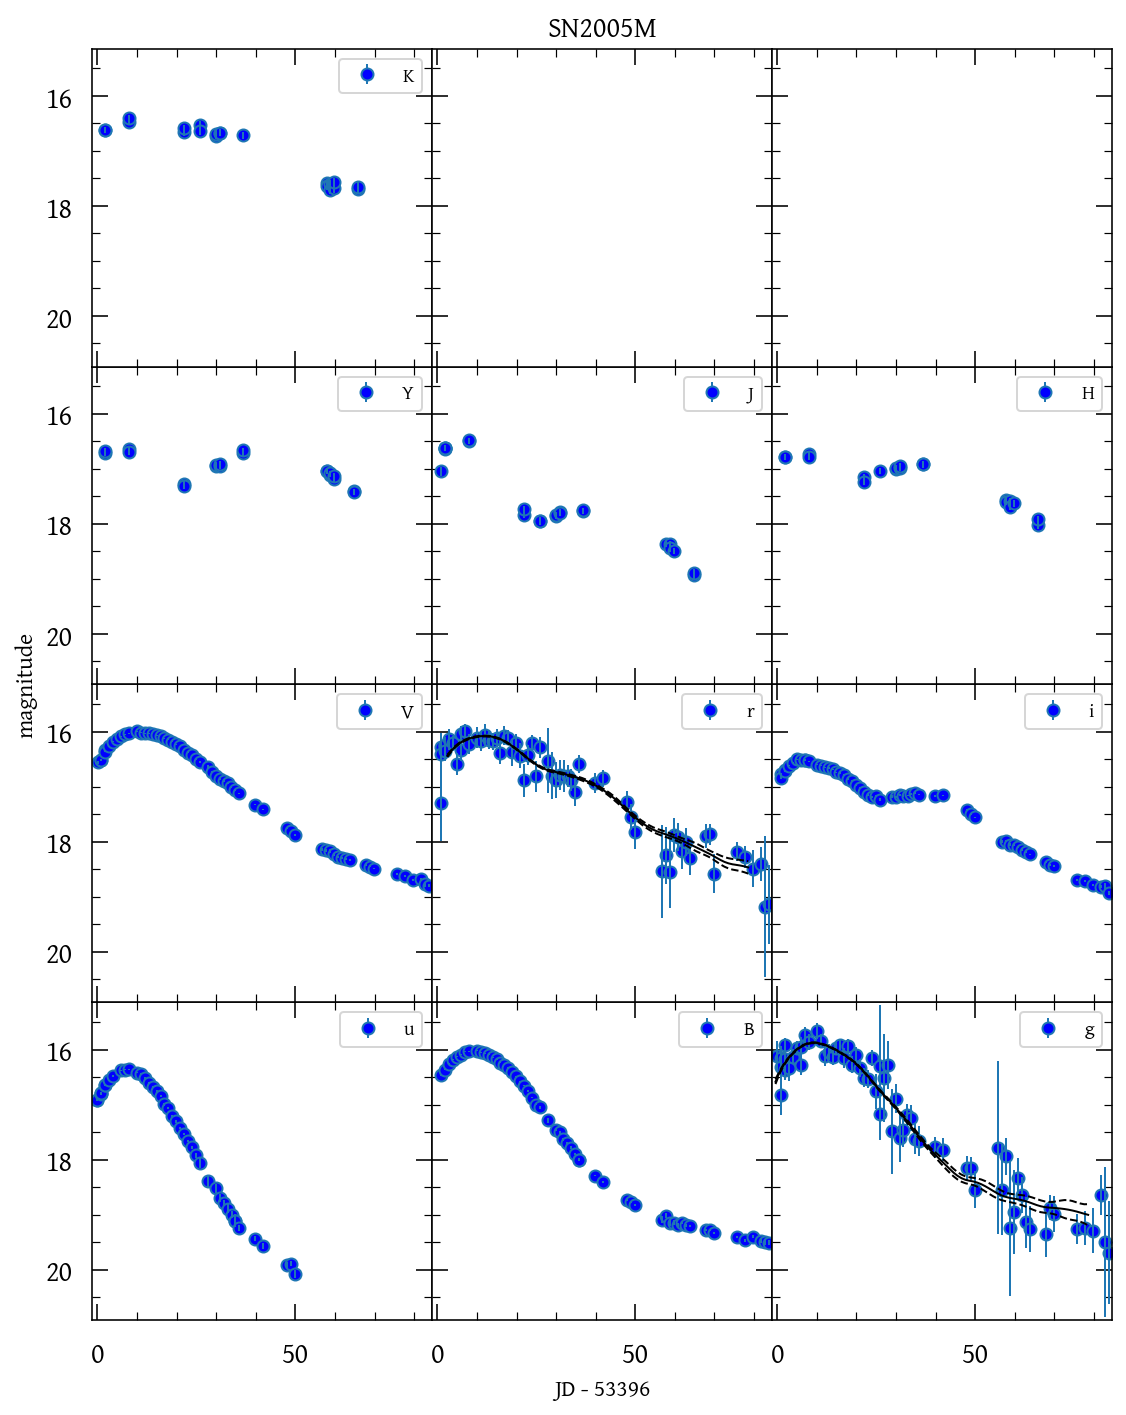

53405.81525944654


In [123]:
steps = [1, 2, 5, 10, 20]

sn = snpy.import_lc('csp_data/SN2005M_snpy.txt')
sn.choose_model(SNOOPY_MODEL)
sn.fit(['g', 'r'])
sn.plot()
plt.show()
print(sn.Tmax)

cadences_list = []
cadences = {band:None for band in sn.allbands()}
for band in sn.allbands():
    lc_len = len(sn.data[band].mask)
    lc_times = sn.data[band].MJD
    cadences[band] = np.mean(np.diff(lc_times))

# fits for multiple cadences
bands = ['g', 'r']

for step in steps:
    sn = snpy.import_lc('csp_data/SN2005M_snpy.txt')
    sn.choose_model(SNOOPY_MODEL)
    
    for band in bands:
        # unchanged observations
#         sn.data[band].e_flux = step*sn.data[band].e_flux
#         sn.data[band]._eflux = step*sn.data[band]._eflux
#         sn.data[band].e_mag = step*sn.data[band].e_mag
        
        # randomise observations within uncertinties
        sn.data[band].e_flux = step*sn.data[band].e_flux
        sn.data[band]._eflux = step*sn.data[band]._eflux

        zp = sn.data[band].mag + 2.5*np.log10(sn.data[band].flux)
        new_flux = np.random.normal(sn.data[band].flux, sn.data[band].e_flux)
        sn.data[band].flux = new_flux

        new_mag = -2.5*np.log10(new_flux) + zp
        new_mag_err = np.abs( 2.5*sn.data[band].e_flux/(new_flux*np.log(10)) )
        sn.data[band].mag = new_mag
        sn.data[band].magnitude = new_mag
        sn.data[band].e_mag = new_mag_err

    sn.fit(bands)
    sn.plot()
    plt.show()
    print(sn.Tmax)

In [165]:
sn.summary()

--------------------------------------------------------------------------------
SN  SN2004eo
z = 0.0157          zcmb = 0.0147          ra=308.22580         dec=  9.92850 
Data in the following bands: g,  r,  i,  u,  B,  V,  J,  H,  K,  Y,  
Fit results (if any):
   st = 0.823  +/-  0.007  +/- 0.030 (sys)
   Tmax = 53278.770  +/-  0.071  +/- 0.340 (sys)
   gmax = 15.042  +/-  0.012  +/- 0.014 (sys)
   rmax = 15.017  +/-  0.008  +/- 0.022 (sys)
